# Volatility Forecasting: Realized Volatility Change Prediction

This notebook implements a comprehensive volatility forecasting framework:
- Calculate rolling realized volatility (RV) from 15-min data
- Upscale to daily frequency
- Compute technical indicators on the volatility path: RSI, autocorrelation (lagged)
- Feature engineering: Fourier analysis, SARIMA forecasts
- Models: RandomForest (with hyperparameter tuning), Linear Regression, HAR-RV, HAR-X, Neural Network
- Target: Future FORECAST_TARGET-day mean RV change (rv_logdiff = log(rv_fwd) - log(rv_today))
- Split: 60% train, 20% validation, 20% test
- No lookahead: use only past data for predictions
- Evaluation: RMSE, MAE (on rv_diff and rv_logdiff), directional accuracy, Pearson correlation
- Regime analysis: Performance by volatility quantiles and current regime conditioning

**Note**: Adjust `ROLLING_WINDOW` and `FORECAST_TARGET` parameters in Cell 1 to change the model configuration.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from scipy import fft, signal
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# ============================================================================
# CONFIGURATION - Adjust these parameters and toggles
# ============================================================================

# ============================================================================
# CORE PARAMETERS
# ============================================================================
ROLLING_WINDOW = 30    # Rolling window size for predictor (e.g., 21 = 21-day rolling mean)
FORECAST_TARGET = 7   # Forecast target horizon (e.g., 21 = next 21-day mean vol)

# ============================================================================
# FEATURE TOGGLES (Performance optimization)
# ============================================================================
ENABLE_SARIMA = True      # Set False to skip SARIMA features (faster)
ENABLE_FOURIER = True     # Set False to skip Fourier features (faster)
SARIMA_REFIT_FREQ = 5     # Refit SARIMA every N days (carry forward forecast otherwise)

# ============================================================================
# DATA QUALITY FILTERS
# ============================================================================
MIN_BARS_PER_DAY = 20     # Minimum 15-min bars per day (filter partial days)
FILTER_WEEKENDS = True    # Filter out weekends
FILTER_ZERO_RV = True     # Filter days with zero RV (invalid)

# ============================================================================
# NEURAL NETWORK TRAINING PARAMETERS
# ============================================================================
NN_EPOCHS = 500           # Maximum training epochs
NN_PATIENCE = 50          # Early stopping patience
NN_BATCH_SIZE = 64        # Batch size (increased for efficiency)

# Technical indicator parameters
RSI_PERIOD = 14        # RSI period (on vol path)
AUTOCORR_LAGS = [1, 2, 3, 5, 10]  # Autocorrelation lags to compute (on vol path)

# Additional feature parameters
RV_RATIO_LOOKBACK_20D = 20  # Lookback for rv_today / rv_20_bars_ago
RV_RATIO_2D_14D = (2, 14)   # Lookback for rv_2d_ago / rv_14d_ago

# Time series analysis parameters
FOURIER_WINDOW = 63         # Rolling window for Fourier analysis (e.g., 63 = ~3 months)
SARIMA_WINDOW = 252         # Rolling window for SARIMA fitting (e.g., 252 = 1 year)
# SARIMA parameters based on ACF/PACF analysis:
# - PACF: highest at k=1, significant up to k=5 → p=1 (AR order)
# - ACF: doesn't cut off, decays slowly → non-stationary → d=1 (differencing needed)
# - ACF: highest at beginning → q=1 (MA order, starting point)
SARIMA_ORDER = (1, 1, 1)    # ARIMA order (p, d, q) - p=1 from PACF, d=1 for non-stationary, q=1 starting point
SARIMA_SEASONAL = (1, 1, 1, 5)  # Seasonal order (P, D, Q, s) - s=5 for weekly pattern, P=1, D=1, Q=1 starting point

print(f"Configuration:")
print(f"  Rolling window (predictor): {ROLLING_WINDOW} days")
print(f"  Forecast target: {FORECAST_TARGET} days")
print(f"  RSI period: {RSI_PERIOD} days")
print(f"  Autocorrelation lags: {AUTOCORR_LAGS}")
print(f"  RV ratio features: rv_today/rv_{RV_RATIO_LOOKBACK_20D}d_ago, rv_{RV_RATIO_2D_14D[0]}d_ago/rv_{RV_RATIO_2D_14D[1]}d_ago")
print(f"  Additional features: Time (dow, wom, moy), Ranks (rsi, rv_ratio, rv_21d_ratio), Correlations, RV vs 21d mean (bool, ratio, rank), RV lags (t-1, t-2, t-3, mean, std, norm)")
print(f"  Time series features: Fourier (rolling {FOURIER_WINDOW}d), SARIMA forecast (rolling {SARIMA_WINDOW}d)")
print(f"  Model: Future {FORECAST_TARGET}-Day RV Change (rv_logdiff) = f(RSI, Autocorr, RV Ratios, Time, Ranks, Advanced Features)")
print(f"  Hyperparameter tuning: TimeSeriesSplit on train, final selection on validation, RandomForest")
print(f"  Feature toggles: SARIMA={ENABLE_SARIMA}, Fourier={ENABLE_FOURIER}")
print(f"  Data filters: min_bars_per_day={MIN_BARS_PER_DAY}, filter_weekends={FILTER_WEEKENDS}, filter_zero_rv={FILTER_ZERO_RV}")
print(f"  NN training: epochs={NN_EPOCHS}, patience={NN_PATIENCE}, batch_size={NN_BATCH_SIZE}")
print(f"  Baseline: Linear Regression for comparison")
print(f"  Benchmarks: HAR-RV, HAR-X")
print(f"  Neural Network: Shallow MLP (nonlinear benchmark)")
print()


Configuration:
  Rolling window (predictor): 30 days
  Forecast target: 7 days
  RSI period: 14 days
  Autocorrelation lags: [1, 2, 3, 5, 10]
  RV ratio features: rv_today/rv_20d_ago, rv_2d_ago/rv_14d_ago
  Additional features: Time (dow, wom, moy), Ranks (rsi, rv_ratio, rv_21d_ratio), Correlations, RV vs 21d mean (bool, ratio, rank), RV lags (t-1, t-2, t-3, mean, std, norm)
  Time series features: Fourier (rolling 63d), SARIMA forecast (rolling 252d)
  Model: Future 7-Day RV Change (rv_logdiff) = f(RSI, Autocorr, RV Ratios, Time, Ranks, Advanced Features)
  Hyperparameter tuning: TimeSeriesSplit on train, final selection on validation, RandomForest
  Feature toggles: SARIMA=True, Fourier=True
  Data filters: min_bars_per_day=20, filter_weekends=True, filter_zero_rv=True
  NN training: epochs=500, patience=50, batch_size=64
  Baseline: Linear Regression for comparison
  Benchmarks: HAR-RV, HAR-X
  Neural Network: Shallow MLP (nonlinear benchmark)



In [65]:
# Load SPY 10y data following the repo pattern
csv_path = Path('../../10y data/SPY_15m_prices.csv')
df = pd.read_csv(csv_path)

# Find date column and set as index
date_cols = [c for c in df.columns if c.lower() in ['date','datetime','timestamp']]
if not date_cols:
    raise ValueError(f"No date/datetime column found. Found columns: {df.columns.tolist()}")

# Parse datetime with UTC, sort, then convert to America/New_York timezone for trading session
# Note: This converts to trading day timezone but does NOT filter by trading hours
df.index = pd.to_datetime(df[date_cols[0]], utc=True, errors='coerce')
df = df.drop(columns=[date_cols[0]]).sort_index()
# Convert to America/New_York timezone (trading day session, all hours included)
df.index = df.index.tz_convert('America/New_York')

# Map close column (handle SPY_close or close)
close_col = None
for col in df.columns:
    if 'close' in col.lower():
        close_col = col
        break

if close_col is None:
    raise ValueError(f"No close column found. Available columns: {df.columns.tolist()}")

# Ensure close exists
df['close'] = df[close_col].astype(float)

print(f"Loaded {len(df):,} rows")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Close column: {close_col}")
df.head()


Loaded 159,764 rows
Date range: 2015-11-20 04:00:00-05:00 to 2025-11-17 19:45:00-05:00
Close column: SPY_close


,SPY_close,SPY_high,SPY_volume,SPY_open,SPY_low,close
date,,,,,,
2015-11-20 04:00:00-05:00,208.53,208.75,940.0,208.75,208.53,208.53
2015-11-20 04:15:00-05:00,208.58,208.58,4300.0,208.58,208.58,208.58
2015-11-20 04:30:00-05:00,208.80,208.85,11734.0,208.52,208.52,208.80
2015-11-20 04:45:00-05:00,208.85,208.90,3182.0,208.87,208.83,208.85
2015-11-20 05:00:00-05:00,208.75,208.78,6600.0,208.73,208.73,208.75


In [66]:
# Compute log returns from 15-min data
ret_15m = np.log(df['close']).diff().dropna()

print(f"15-min returns computed: {len(ret_15m):,} observations")
print(f"Return stats:")
print(ret_15m.describe())


15-min returns computed: 159,763 observations
Return stats:
count    159763.000000
mean          0.000007
std           0.001425
min          -0.058999
25%          -0.000373
50%           0.000015
75%           0.000416
max           0.051561
Name: close, dtype: float64


In [ ]:
# Upscale to daily: aggregate 15-min returns to daily
# Group by date and sum squared returns for realized variance, then take sqrt for RV
# Use pd.Grouper to group by date (normalize to date, ignoring time)
ret_15m_series = pd.Series(ret_15m)

# Count bars per day for quality filtering
bars_per_day = ret_15m_series.groupby(pd.Grouper(freq='D')).count()

# Daily realized variance = sum of squared 15-min returns per day
daily_rv_squared = ret_15m_series.groupby(pd.Grouper(freq='D')).apply(lambda x: (x ** 2).sum())

# Daily realized volatility = sqrt(realized variance)
daily_rv = np.sqrt(daily_rv_squared)

# Annualize: multiply by sqrt(252) to get annualized volatility
daily_rv = daily_rv * np.sqrt(252)

# ============================================================================
# DATA QUALITY FILTERING
# ============================================================================
# Remove NaN days (weekends/holidays with no data)
daily_rv = daily_rv.dropna()

# Filter by minimum bars per day (remove partial days)
if MIN_BARS_PER_DAY > 0:
    valid_days = bars_per_day[bars_per_day >= MIN_BARS_PER_DAY].index
    daily_rv = daily_rv[daily_rv.index.isin(valid_days)]
    print(f"Filtered to days with >= {MIN_BARS_PER_DAY} bars: {len(daily_rv)} days remaining")

# Filter out weekends (if enabled)
if FILTER_WEEKENDS:
    daily_rv = daily_rv[daily_rv.index.dayofweek < 5]  # Keep only Mon-Fri (0-4)
    print(f"After weekend filter: {len(daily_rv)} days remaining")

# Remove days where RV is 0 (invalid - RV can never be 0)
if FILTER_ZERO_RV:
    initial_count = len(daily_rv)
    daily_rv = daily_rv[daily_rv > 0]
    print(f"After zero-RV filter: {len(daily_rv)} days remaining (removed {initial_count - len(daily_rv)} zero-RV days)")

print(f"Daily RV computed (annualized): {len(daily_rv)} trading days")
print(f"Date range: {daily_rv.index.min()} to {daily_rv.index.max()}")
print(f"\nDaily RV stats (annualized):")
print(daily_rv.describe())
print(f"\nDays removed:")
print(f"  Zero RV days: {(daily_rv_squared.dropna() == 0).sum()}")
print(f"  After all removals days: {len(daily_rv_squared.dropna()) - len(daily_rv)}")


Filtered to days with >= 20 bars: 2512 days remaining
After weekend filter: 2512 days remaining
After zero-RV filter: 2512 days remaining (removed 0 zero-RV days)
Daily RV computed (annualized): 2512 trading days
Date range: 2015-11-20 00:00:00-05:00 to 2025-11-17 00:00:00-05:00

Daily RV stats (annualized):
count    2512.000000
mean        0.142197
std         0.110962
min         0.028534
25%         0.078794
50%         0.112801
75%         0.171133
max         1.323340
Name: close, dtype: float64

Days removed:
  Zero RV days: 1139
  Weekend days: 1139


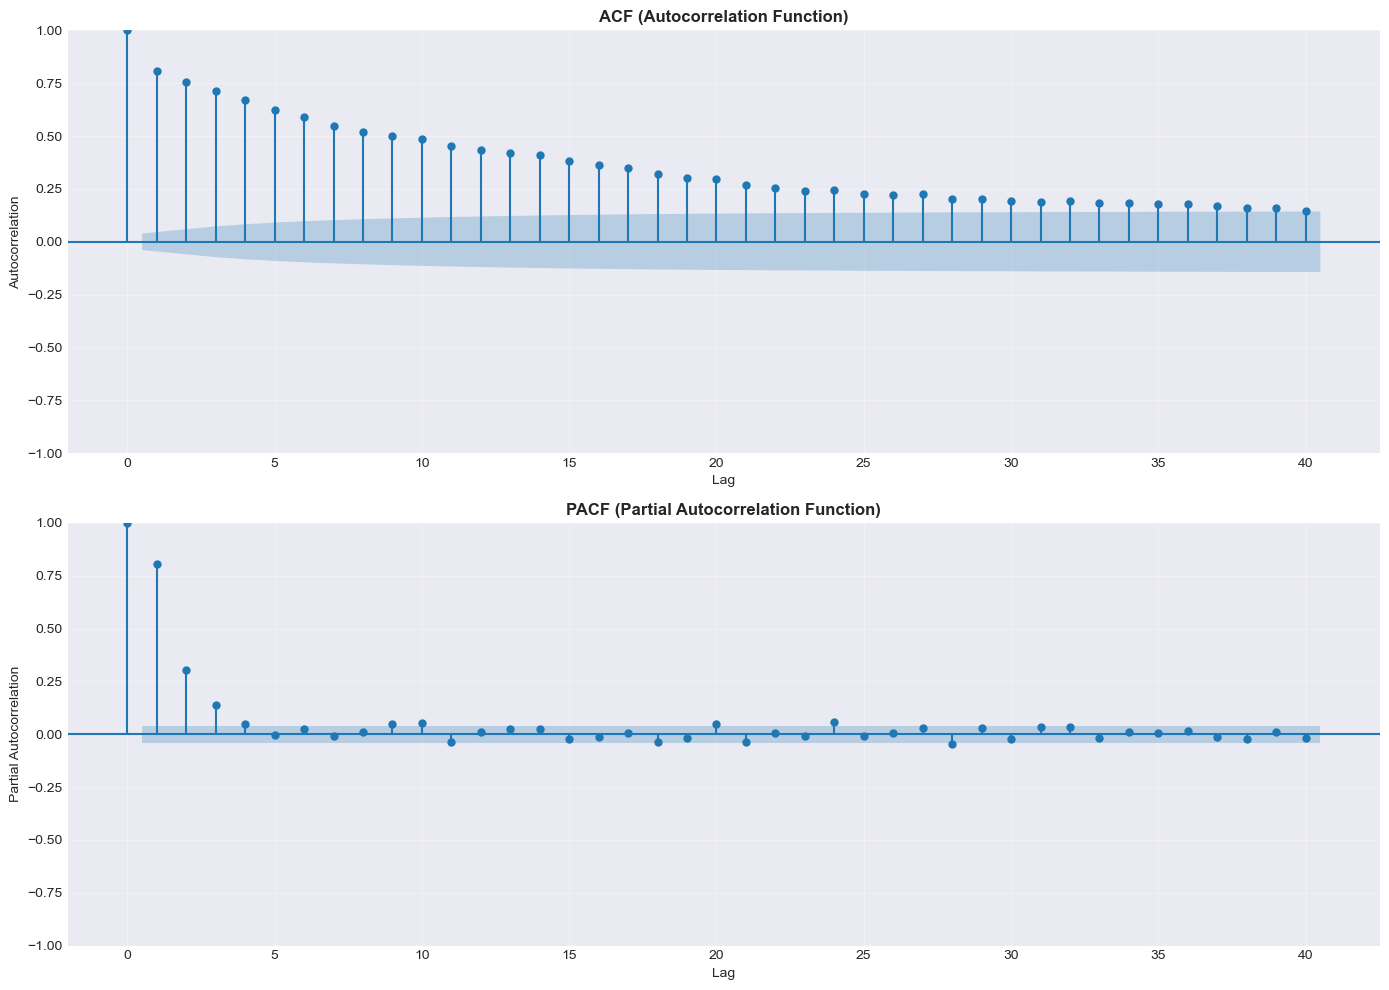

In [68]:

# Plot ACF and PACF to help determine SARIMA parameters
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

rv_clean = daily_rv.dropna()
plot_acf(rv_clean, lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF (Autocorrelation Function)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')
axes[0].grid(True, alpha=0.3)

plot_pacf(rv_clean, lags=40, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('PACF (Partial Autocorrelation Function)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [69]:
# Helper function to compute RSI on a series
def compute_rsi(series, period=14):
    """
    Compute Relative Strength Index (RSI) on a series.
    
    Parameters:
    - series: pd.Series
    - period: RSI period
    
    Returns:
    - pd.Series of RSI values (0-100)
    """
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=period).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Helper function to compute autocorrelation at specific lags
def compute_autocorr(series, lag):
    """
    Compute autocorrelation at a specific lag.
    
    Parameters:
    - series: pd.Series
    - lag: lag value
    
    Returns:
    - pd.Series of autocorrelation values
    """
    return series.autocorr(lag=lag) if len(series) > lag else np.nan

def compute_rolling_autocorr(series, window, lag):
    """
    Compute rolling autocorrelation at a specific lag.
    
    Parameters:
    - series: pd.Series
    - window: rolling window size
    - lag: lag value
    
    Returns:
    - pd.Series of rolling autocorrelation values
    """
    result = pd.Series(index=series.index, dtype=float)
    
    for i in range(window + lag - 1, len(series)):
        window_data = series.iloc[i - window + 1:i + 1]
        if len(window_data) >= window:
            x = window_data.iloc[lag:].values
            y = window_data.iloc[:-lag].values
            if len(x) > 1 and np.std(x) > 0 and np.std(y) > 0:
                corr = np.corrcoef(x, y)[0, 1]
                result.iloc[i] = corr
            else:
                result.iloc[i] = np.nan
        else:
            result.iloc[i] = np.nan
    
    return result

# Test functions
print("Testing RSI function:")
test_series = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
test_rsi = compute_rsi(test_series, period=14)
print(f"RSI sample: {test_rsi.iloc[-1]:.2f}")
print()


Testing RSI function:
RSI sample: 100.00



TARGET SANITY CHECKS
✓ Target alignment checks passed
✓ No NaNs in targets (length: 2505)

rv_diff statistics:
  Mean: 0.000066
  Std:  0.072201
  Min:  -0.774482
  Max:  0.637180

rv_logdiff statistics:
  Mean: 0.042213
  Std:  0.382907
  Min:  -1.450675
  Max:  2.087961


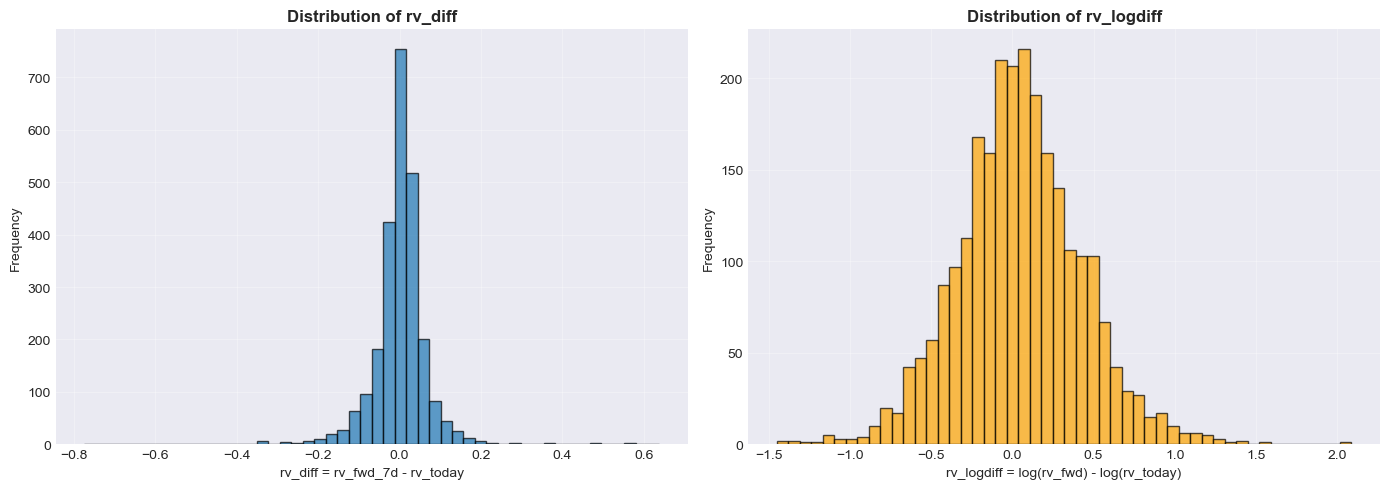


Computing advanced features (this may take a few minutes)...
  Computing Fourier Analysis features...


Fourier features: 100%|██████████| 2450/2450 [00:00<00:00, 10833.98it/s]


  ✓ Fourier features complete
  Computing SARIMA features...


SARIMA features: 100%|██████████| 2261/2261 [05:10<00:00,  7.27it/s]  


  ✓ SARIMA features complete
Advanced features computation complete!
Aligned data with features: 2254 trading days
Date range: 2016-11-18 00:00:00-05:00 to 2025-11-06 00:00:00-05:00

Feature columns:
['rv_today', 'rv_fwd_7d', 'rv_diff_7d', 'rv_logdiff_7d', 'rsi_vol', 'rv_ratio_20d', 'rv_ratio_2d_14d', 'rv_corr_ratio', 'day_of_week', 'week_of_month', 'month_of_year', 'rv_vol_corr_ratio', 'rsi_vol_rank', 'rv_ratio_20d_rank', 'is_rv_gt_21d_mean', 'rv_today_ratio_21d_mean', 'rv_today_ratio_21d_mean_rank', 'autocorr_lag1', 'autocorr_lag2', 'autocorr_lag3', 'autocorr_lag5', 'autocorr_lag10', 'rv_lag1', 'rv_lag2', 'rv_lag5', 'rv_lag10', 'rv_change_1', 'rv_change_5', 'past_mean_7', 'past_mean_diff_7', 'fourier_dominant_freq', 'fourier_dominant_amp', 'fourier_second_freq', 'fourier_second_amp', 'fourier_total_energy', 'sarima_forecast', 'sarima_residual_std']

First few rows:
                           rv_today  rv_fwd_7d  rv_diff_7d  rv_logdiff_7d  \
2016-11-18 00:00:00-05:00  0.068663   0.066

In [ ]:
# Target: subsequent FORECAST_TARGET-day rolling window mean vol
# For each time t, compute mean of next FORECAST_TARGET days (t+1 to t+FORECAST_TARGET)
rv_fwd_values = []
rv_fwd_index = []

for i in range(len(daily_rv)):
    if i + FORECAST_TARGET < len(daily_rv):  # Need at least FORECAST_TARGET days ahead
        future_mean = daily_rv.iloc[i+1:i+1+FORECAST_TARGET].mean()
        rv_fwd_values.append(future_mean)
        rv_fwd_index.append(daily_rv.index[i])

rv_fwd_7d = pd.Series(rv_fwd_values, index=rv_fwd_index)

# Compute RV change targets
# rv_diff = rv_fwd_7d - RV_t (simple difference)
rv_diff = rv_fwd_7d - daily_rv.loc[rv_fwd_7d.index]
# rv_logdiff = log(rv_fwd_7d + eps) - log(RV_t + eps) (log-difference, more stable)
eps = 1e-12
rv_logdiff = np.log(rv_fwd_7d + eps) - np.log(daily_rv.loc[rv_fwd_7d.index] + eps)

# ============================================================================
# SANITY CHECKS: Target alignment and statistics
# ============================================================================
print("=" * 70)
print("TARGET SANITY CHECKS")
print("=" * 70)

# Check alignment: features at time t predict rv_fwd_7d from t+1..t+7
assert len(rv_fwd_7d) == len(rv_diff), "rv_fwd_7d and rv_diff must have same length"
assert len(rv_fwd_7d) == len(rv_logdiff), "rv_fwd_7d and rv_logdiff must have same length"
assert rv_fwd_7d.index.equals(rv_diff.index), "rv_fwd_7d and rv_diff must have same index"
assert rv_fwd_7d.index.equals(rv_logdiff.index), "rv_fwd_7d and rv_logdiff must have same index"

# Check for NaNs
assert rv_fwd_7d.notna().all(), "rv_fwd_7d contains NaNs"
assert rv_diff.notna().all(), "rv_diff contains NaNs"
assert rv_logdiff.notna().all(), "rv_logdiff contains NaNs"

print("✓ Target alignment checks passed")
print(f"✓ No NaNs in targets (length: {len(rv_fwd_7d)})")

# Print summary statistics
print(f"\nrv_diff statistics:")
print(f"  Mean: {rv_diff.mean():.6f}")
print(f"  Std:  {rv_diff.std():.6f}")
print(f"  Min:  {rv_diff.min():.6f}")
print(f"  Max:  {rv_diff.max():.6f}")

print(f"\nrv_logdiff statistics:")
print(f"  Mean: {rv_logdiff.mean():.6f}")
print(f"  Std:  {rv_logdiff.std():.6f}")
print(f"  Min:  {rv_logdiff.min():.6f}")
print(f"  Max:  {rv_logdiff.max():.6f}")

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(rv_diff.dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of rv_diff', fontsize=12, fontweight='bold')
axes[0].set_xlabel('rv_diff = rv_fwd_7d - rv_today')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

axes[1].hist(rv_logdiff.dropna(), bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_title('Distribution of rv_logdiff', fontsize=12, fontweight='bold')
axes[1].set_xlabel('rv_logdiff = log(rv_fwd) - log(rv_today)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)

# Compute technical indicators on the vol path (daily_rv)
# IMPORTANT: All indicators use only past data (no lookahead)
# RSI on vol path - uses rolling window, naturally backward-looking
rsi_vol = compute_rsi(daily_rv, period=RSI_PERIOD)

# Rolling autocorrelation at different lags on vol path
# Each autocorrelation uses a rolling window ending at time t (no future data)
autocorr_features = {}
for lag in AUTOCORR_LAGS:
    # Use a rolling window that's at least 2*lag to get meaningful autocorrelation
    # Window ends at time t, so it's backward-looking
    window_size = max(ROLLING_WINDOW, 2 * lag + 5)
    autocorr_features[f'autocorr_lag{lag}'] = compute_rolling_autocorr(daily_rv, window=window_size, lag=lag)

# Additional features: RV ratios and correlations
# Feature 1: rv_today / rv_20_bars_ago (ratio of current to 20 days ago)
# Shift ensures we use past data only (rv at t-20, not future)
rv_ratio_20d = daily_rv / daily_rv.shift(RV_RATIO_LOOKBACK_20D)

# Feature 2: rv_2d_ago / rv_14d_ago (ratio of 2 days ago to 14 days ago)
# Both shifts ensure we use past data only
rv_ratio_2d_14d = daily_rv.shift(RV_RATIO_2D_14D[0]) / daily_rv.shift(RV_RATIO_2D_14D[1])

# Feature 3: Rolling correlation between (rv_2d_ago / rv_14d_ago) and rv_today
# Compute rolling correlation of the ratio series with current RV
# Use a rolling window for correlation (ending at time t, so backward-looking)
corr_window = max(ROLLING_WINDOW, 20)
rv_ratio_2d_14d_series = daily_rv.shift(RV_RATIO_2D_14D[0]) / daily_rv.shift(RV_RATIO_2D_14D[1])
rv_corr_ratio = pd.Series(index=daily_rv.index, dtype=float)
for i in range(corr_window, len(daily_rv)):
    # Window ends at time i, so uses only data up to time i (no lookahead)
    window_ratio = rv_ratio_2d_14d_series.iloc[i-corr_window+1:i+1]
    window_rv = daily_rv.iloc[i-corr_window+1:i+1]
    mask = ~(window_ratio.isna() | window_rv.isna())
    if mask.sum() > 5:
        corr_val = np.corrcoef(window_ratio[mask].values, window_rv[mask].values)[0, 1]
        rv_corr_ratio.iloc[i] = corr_val if not np.isnan(corr_val) else np.nan

# Feature 4: Time-based features (day of week, week of month, month of year)
# These are deterministic and don't cause lookahead
day_of_week = daily_rv.index.dayofweek  # 0=Monday, 6=Sunday
week_of_month = (daily_rv.index.day - 1) // 7 + 1  # Week 1-5 within month
month_of_year = daily_rv.index.month  # 1-12

# Feature 5: Rolling correlation between daily_rv and rv_corr_ratio
# Compute rolling correlation between vol and the correlation ratio
rv_vol_corr_ratio = pd.Series(index=daily_rv.index, dtype=float)
for i in range(corr_window, len(daily_rv)):
    # Window ends at time i, so uses only data up to time i (no lookahead)
    window_vol = daily_rv.iloc[i-corr_window+1:i+1]
    window_corr = rv_corr_ratio.iloc[i-corr_window+1:i+1]
    mask = ~(window_vol.isna() | window_corr.isna())
    if mask.sum() > 5:
        corr_val = np.corrcoef(window_vol[mask].values, window_corr[mask].values)[0, 1]
        rv_vol_corr_ratio.iloc[i] = corr_val if not np.isnan(corr_val) else np.nan

# Feature 6: Historical rank of rsi_vol (backwards looking)
# Rank RSI within expanding window (all historical data up to time t)
rsi_vol_rank = rsi_vol.expanding(min_periods=50).rank(pct=True)

# Feature 7: Historical rank of rv_ratio_20d (backwards looking)
# Rank RV ratio within expanding window (all historical data up to time t)
rv_ratio_20d_rank = rv_ratio_20d.expanding(min_periods=50).rank(pct=True)

# Feature 8: Boolean - is today's RV > 21-day rolling mean?
# Compute 21-day rolling mean (for comparison only, not as feature)
rolling_rv_21d = daily_rv.rolling(window=21, min_periods=21).mean()
is_rv_gt_21d_mean = (daily_rv > rolling_rv_21d).astype(int)  # 1 if True, 0 if False

# Feature 9: Ratio of current RV to 21-day rolling mean
rv_today_ratio_21d_mean = daily_rv / rolling_rv_21d

# Feature 10: Historical rank of the ratio (backwards looking)
# Rank the ratio within expanding window (all historical data up to time t)
rv_today_ratio_21d_mean_rank = rv_today_ratio_21d_mean.expanding(min_periods=50).rank(pct=True)

# Feature 11: Safe backward-looking RV features (no data leakage)
# These features use only past RV data, no future targets
rv_lag1 = daily_rv.shift(1)
rv_lag2 = daily_rv.shift(2)
rv_lag5 = daily_rv.shift(5)
rv_lag10 = daily_rv.shift(10)
rv_change_1 = daily_rv - daily_rv.shift(1)  # Change from t-1 to t
rv_change_5 = daily_rv - daily_rv.shift(5)  # Change from t-5 to t
past_mean_7 = daily_rv.shift(1).rolling(window=7, min_periods=1).mean()  # Past 7-day mean (ending at t-1)
past_mean_diff_7 = past_mean_7 - daily_rv  # Difference between past mean and current RV

# ============================================================================
# ============================================================================
# All features computed in rolling windows to avoid lookahead
ADVANCED_WINDOW = 63  # Rolling window for advanced features

print("Computing advanced features (this may take a few minutes)...")

# Helper function for rolling window feature computation
# ============================================================================
# FOURIER ANALYSIS FEATURES
# ============================================================================
if ENABLE_FOURIER:
    print("  Computing Fourier Analysis features...")
    fourier_dominant_freq = pd.Series(index=daily_rv.index, dtype=float)
    fourier_dominant_amp = pd.Series(index=daily_rv.index, dtype=float)
    fourier_second_freq = pd.Series(index=daily_rv.index, dtype=float)
    fourier_second_amp = pd.Series(index=daily_rv.index, dtype=float)
    fourier_total_energy = pd.Series(index=daily_rv.index, dtype=float)

    for i in tqdm(range(FOURIER_WINDOW - 1, len(daily_rv)), desc="Fourier features"):
        window_data = daily_rv.iloc[max(0, i - FOURIER_WINDOW + 1):i + 1].values
        if len(window_data) >= 20:
            try:
                # FFT
                fft_vals = fft.fft(window_data)
                freqs = fft.fftfreq(len(window_data))
                power = np.abs(fft_vals)**2
                
                # Dominant frequency (excluding DC component)
                power[0] = 0  # Remove DC
                dominant_idx = np.argmax(power[1:len(power)//2]) + 1
                fourier_dominant_freq.iloc[i] = abs(freqs[dominant_idx])
                fourier_dominant_amp.iloc[i] = power[dominant_idx]
                
                # Second dominant frequency
                power[dominant_idx] = 0
                second_idx = np.argmax(power[1:len(power)//2]) + 1
                fourier_second_freq.iloc[i] = abs(freqs[second_idx])
                fourier_second_amp.iloc[i] = power[second_idx]
                
                # Total energy
                fourier_total_energy.iloc[i] = np.sum(power)
            except:
                pass
    print("  ✓ Fourier features complete")
else:
    print("  Skipping Fourier features (ENABLE_FOURIER=False)")
    fourier_dominant_freq = pd.Series(index=daily_rv.index, dtype=float)
    fourier_dominant_amp = pd.Series(index=daily_rv.index, dtype=float)
    fourier_second_freq = pd.Series(index=daily_rv.index, dtype=float)
    fourier_second_amp = pd.Series(index=daily_rv.index, dtype=float)
    fourier_total_energy = pd.Series(index=daily_rv.index, dtype=float)

# ============================================================================
# SARIMA FEATURES
# ============================================================================
if ENABLE_SARIMA:
    print("  Computing SARIMA features...")
    sarima_forecast = pd.Series(index=daily_rv.index, dtype=float)
    sarima_residual_std = pd.Series(index=daily_rv.index, dtype=float)
    
    last_fitted_model = None
    last_fitted_idx = -1

    for i in tqdm(range(SARIMA_WINDOW - 1, len(daily_rv)), desc="SARIMA features"):
        window_data = daily_rv.iloc[max(0, i - SARIMA_WINDOW + 1):i + 1].values
        if len(window_data) >= SARIMA_WINDOW // 2:  # Need minimum data
            # Refit only every SARIMA_REFIT_FREQ days, otherwise carry forward forecast
            if (i - last_fitted_idx) >= SARIMA_REFIT_FREQ or last_fitted_model is None:
                try:
                    # Fit SARIMA model
                    model = SARIMAX(window_data, order=SARIMA_ORDER, seasonal_order=SARIMA_SEASONAL, 
                                   enforce_stationarity=False, enforce_invertibility=False)
                    fitted_model = model.fit(disp=False, maxiter=50)
                    last_fitted_model = fitted_model
                    last_fitted_idx = i
                except Exception as e:
                    # If SARIMA fails, use NaN or last successful forecast
                    if last_fitted_model is not None:
                        try:
                            forecast = last_fitted_model.forecast(steps=1)
                            sarima_forecast.iloc[i] = forecast[0] if len(forecast) > 0 else np.nan
                            residuals = last_fitted_model.resid
                            sarima_residual_std.iloc[i] = np.std(residuals) if len(residuals) > 0 else np.nan
                        except:
                            sarima_forecast.iloc[i] = np.nan
                            sarima_residual_std.iloc[i] = np.nan
                    else:
                        sarima_forecast.iloc[i] = np.nan
                        sarima_residual_std.iloc[i] = np.nan
                    continue
            
            # Forecast next value (using last fitted model)
            try:
                forecast = last_fitted_model.forecast(steps=1)
                sarima_forecast.iloc[i] = forecast[0] if len(forecast) > 0 else np.nan
                
                # Residual standard deviation
                residuals = last_fitted_model.resid
                sarima_residual_std.iloc[i] = np.std(residuals) if len(residuals) > 0 else np.nan
            except Exception:
                sarima_forecast.iloc[i] = np.nan
                sarima_residual_std.iloc[i] = np.nan
    print("  ✓ SARIMA features complete")
else:
    print("  Skipping SARIMA features (ENABLE_SARIMA=False)")
    sarima_forecast = pd.Series(index=daily_rv.index, dtype=float)
    sarima_residual_std = pd.Series(index=daily_rv.index, dtype=float)



print("Advanced features computation complete!")

# Create aligned dataframe
df_features = pd.DataFrame({
    'rv_today': daily_rv,
    f'rv_fwd_{FORECAST_TARGET}d': rv_fwd_7d,   
    f'rv_diff_{FORECAST_TARGET}d': rv_diff,    # RV difference: rv_fwd_7d - rv_today
    f'rv_logdiff_{FORECAST_TARGET}d': rv_logdiff,  # RV log-difference: log(rv_fwd) - log(rv_today) [TRAINING TARGET]
    'rsi_vol': rsi_vol,
    'rv_ratio_20d': rv_ratio_20d,                 # rv_today / rv_20_bars_ago
    'rv_ratio_2d_14d': rv_ratio_2d_14d,          # rv_2d_ago / rv_14d_ago
    'rv_corr_ratio': rv_corr_ratio,               # Rolling correlation of ratio with current RV
    'day_of_week': day_of_week,                   # Day of week (0=Mon, 6=Sun)
    'week_of_month': week_of_month,                # Week of month (1-5)
    'month_of_year': month_of_year,                # Month of year (1-12)
    'rv_vol_corr_ratio': rv_vol_corr_ratio,      # Rolling correlation between vol and rv_corr_ratio
    'rsi_vol_rank': rsi_vol_rank,                 # Historical rank of RSI (backwards looking)
    'rv_ratio_20d_rank': rv_ratio_20d_rank,       # Historical rank of rv_ratio_20d (backwards looking)
    'is_rv_gt_21d_mean': is_rv_gt_21d_mean,       # Boolean: is today's RV > 21d rolling mean?
    'rv_today_ratio_21d_mean': rv_today_ratio_21d_mean,  # Ratio: current RV / 21d rolling mean
    'rv_today_ratio_21d_mean_rank': rv_today_ratio_21d_mean_rank  # Historical rank of the ratio
})

# Add autocorrelation features
for feat_name, feat_series in autocorr_features.items():
    df_features[feat_name] = feat_series

# Add safe backward-looking RV features (no data leakage)
df_features['rv_lag1'] = rv_lag1
df_features['rv_lag2'] = rv_lag2
df_features['rv_lag5'] = rv_lag5
df_features['rv_lag10'] = rv_lag10
df_features['rv_change_1'] = rv_change_1
df_features['rv_change_5'] = rv_change_5
df_features['past_mean_7'] = past_mean_7
df_features['past_mean_diff_7'] = past_mean_diff_7







# Add Fourier Analysis features
df_features['fourier_dominant_freq'] = fourier_dominant_freq
df_features['fourier_dominant_amp'] = fourier_dominant_amp
df_features['fourier_second_freq'] = fourier_second_freq
df_features['fourier_second_amp'] = fourier_second_amp
df_features['fourier_total_energy'] = fourier_total_energy

# Add SARIMA features
df_features['sarima_forecast'] = sarima_forecast
df_features['sarima_residual_std'] = sarima_residual_std

# Drop rows with NaN (need enough history for all features + FORECAST_TARGET days ahead)
# Also ensure no zero RV values
df_features = df_features.dropna()
df_features = df_features[df_features['rv_today'] > 0]

print(f"Aligned data with features: {len(df_features)} trading days")
print(f"Date range: {df_features.index.min()} to {df_features.index.max()}")
print(f"\nFeature columns:")
print(df_features.columns.tolist())
print(f"\nFirst few rows:")
print(df_features.head(10))


In [71]:
# Split into train/val/test: 60/20/20
n_total = len(df_features)
n_train = int(0.6 * n_total)
n_val = int(0.2 * n_total)
n_test = n_total - n_train - n_val

train_data = df_features.iloc[:n_train]
val_data = df_features.iloc[n_train:n_train + n_val]
test_data = df_features.iloc[n_train + n_val:]

print(f"Data split:")
print(f"  Train: {len(train_data)} days ({len(train_data)/n_total*100:.1f}%)")
print(f"    Date range: {train_data.index.min()} to {train_data.index.max()}")
print(f"  Validation: {len(val_data)} days ({len(val_data)/n_total*100:.1f}%)")
print(f"    Date range: {val_data.index.min()} to {val_data.index.max()}")
print(f"  Test: {len(test_data)} days ({len(test_data)/n_total*100:.1f}%)")
print(f"    Date range: {test_data.index.min()} to {test_data.index.max()}")


Data split:
  Train: 1352 days (60.0%)
    Date range: 2016-11-18 00:00:00-05:00 to 2022-04-04 00:00:00-04:00
  Validation: 450 days (20.0%)
    Date range: 2022-04-05 00:00:00-04:00 to 2024-01-19 00:00:00-05:00
  Test: 452 days (20.1%)
    Date range: 2024-01-22 00:00:00-05:00 to 2025-11-06 00:00:00-05:00


In [72]:
# Prepare features and targets using parameters
# Features: RSI(vol), autocorr(vol) at various lags, RV ratios, correlations, time features, ranks
# Target: FORECAST_TARGET-day mean vol
# NOTE: rolling_rv_{ROLLING_WINDOW}d removed as requested

feature_cols = [
    # Basic technical indicators
    'rsi_vol',                          # RSI on vol path
    'rv_ratio_20d',                     # rv_today / rv_20_bars_ago
    'rv_ratio_2d_14d',                  # rv_2d_ago / rv_14d_ago
    'rv_corr_ratio',                    # Rolling correlation of ratio with current RV
    'day_of_week',                      # Day of week (0=Mon, 6=Sun)
    'week_of_month',                    # Week of month (1-5)
    'month_of_year',                    # Month of year (1-12)
    'rv_vol_corr_ratio',                # Rolling correlation between vol and rv_corr_ratio
    'rsi_vol_rank',                     # Historical rank of RSI
    'rv_ratio_20d_rank',                # Historical rank of rv_ratio_20d
    'is_rv_gt_21d_mean',                # Boolean: is today's RV > 21d rolling mean?
    'rv_today_ratio_21d_mean',          # Ratio: current RV / 21d rolling mean
    'rv_today_ratio_21d_mean_rank',     # Historical rank of the ratio
    
    # Safe backward-looking RV features (no data leakage)
    'rv_lag1',                          # RV at t-1
    'rv_lag2',                          # RV at t-2
    'rv_lag5',                          # RV at t-5
    'rv_lag10',                         # RV at t-10
    'rv_change_1',                      # Change from t-1 to t
    'rv_change_5',                      # Change from t-5 to t
    'past_mean_7',                     # Past 7-day mean (ending at t-1)
    'past_mean_diff_7',                 # Difference between past mean and current RV
    
    # Fourier Analysis features
    'fourier_dominant_freq',             # Dominant frequency from FFT
    'fourier_dominant_amp',              # Amplitude of dominant frequency
    'fourier_second_freq',               # Second dominant frequency
    'fourier_second_amp',                # Amplitude of second frequency
    'fourier_total_energy',              # Total energy in frequency domain
    
    # SARIMA features
    'sarima_forecast',                   # SARIMA forecast (next value)
    'sarima_residual_std',               # SARIMA residual standard deviation
] + [f'autocorr_lag{lag}' for lag in AUTOCORR_LAGS]  # Autocorrelation features

# Prepare training data - use rv_logdiff as target (RV change forecasting)
X_train = train_data[feature_cols].values
y_train = train_data[f'rv_logdiff_{FORECAST_TARGET}d'].values

X_val = val_data[feature_cols].values
y_val = val_data[f'rv_logdiff_{FORECAST_TARGET}d'].values

X_test = test_data[feature_cols].values
y_test = test_data[f'rv_logdiff_{FORECAST_TARGET}d'].values

# Also store rv_diff for evaluation metrics
y_train_rv_diff = train_data[f'rv_diff_{FORECAST_TARGET}d'].values
y_val_rv_diff = val_data[f'rv_diff_{FORECAST_TARGET}d'].values
y_test_rv_diff = test_data[f'rv_diff_{FORECAST_TARGET}d'].values

print(f"Feature columns ({len(feature_cols)}):")
for i, col in enumerate(feature_cols):
    print(f"  {i+1}. {col}")

print(f"\nTraining set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Feature columns (33):
  1. rsi_vol
  2. rv_ratio_20d
  3. rv_ratio_2d_14d
  4. rv_corr_ratio
  5. day_of_week
  6. week_of_month
  7. month_of_year
  8. rv_vol_corr_ratio
  9. rsi_vol_rank
  10. rv_ratio_20d_rank
  11. is_rv_gt_21d_mean
  12. rv_today_ratio_21d_mean
  13. rv_today_ratio_21d_mean_rank
  14. rv_lag1
  15. rv_lag2
  16. rv_lag5
  17. rv_lag10
  18. rv_change_1
  19. rv_change_5
  20. past_mean_7
  21. past_mean_diff_7
  22. fourier_dominant_freq
  23. fourier_dominant_amp
  24. fourier_second_freq
  25. fourier_second_amp
  26. fourier_total_energy
  27. sarima_forecast
  28. sarima_residual_std
  29. autocorr_lag1
  30. autocorr_lag2
  31. autocorr_lag3
  32. autocorr_lag5
  33. autocorr_lag10

Training set: 1352 samples
Validation set: 450 samples
Test set: 452 samples


In [ ]:
# ============================================================================
# BASELINE: Linear Regression
# ============================================================================
print("=" * 70)
print("BASELINE: Linear Regression")
print("=" * 70)
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

baseline_pred_train = baseline_model.predict(X_train)
baseline_pred_val = baseline_model.predict(X_val)
baseline_pred_test = baseline_model.predict(X_test)

baseline_r2_train = r2_score(y_train, baseline_pred_train)
baseline_r2_val = r2_score(y_val, baseline_pred_val)
baseline_r2_test = r2_score(y_test, baseline_pred_test)

baseline_rmse_train = np.sqrt(mean_squared_error(y_train, baseline_pred_train))
baseline_rmse_val = np.sqrt(mean_squared_error(y_val, baseline_pred_val))
baseline_rmse_test = np.sqrt(mean_squared_error(y_test, baseline_pred_test))

print(f"Baseline Linear Regression Results:")
print(f"  Train R²: {baseline_r2_train:.4f}, RMSE: {baseline_rmse_train:.6f}")
print(f"  Val R²: {baseline_r2_val:.4f}, RMSE: {baseline_rmse_val:.6f}")
print(f"  Test R²: {baseline_r2_test:.4f}, RMSE: {baseline_rmse_test:.6f}")

# ============================================================================
# RANDOM FOREST WITH HYPERPARAMETER TUNING
# ============================================================================
print("\n" + "=" * 70)
print("RANDOM FOREST: Hyperparameter Tuning (TimeSeriesSplit on Train, Final Selection on Validation)")
print("=" * 70)

# Define parameter grid covering various tree configurations
# Shallow/thin, shallow/wide, deep/wide, deep/thin
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

# Sample random combinations from grid (to balance thoroughness with speed)
# Use 50 random combinations
import random
random.seed(42)
np.random.seed(42)

all_combinations = []
for n_est in param_grid['n_estimators']:
    for max_d in param_grid['max_depth']:
        for min_split in param_grid['min_samples_split']:
            for min_leaf in param_grid['min_samples_leaf']:
                for max_feat in param_grid['max_features']:
                    all_combinations.append({
                        'n_estimators': n_est,
                        'max_depth': max_d,
                        'min_samples_split': min_split,
                        'min_samples_leaf': min_leaf,
                        'max_features': max_feat
                    })

# Sample 50 random combinations
sampled_combinations = random.sample(all_combinations, min(150, len(all_combinations)))

print(f"Testing {len(sampled_combinations)} random parameter combinations...")
print("(This may take a few minutes)")

best_score = -np.inf
best_params = None
best_model = None
results_list = []

for i, params in enumerate(sampled_combinations):
    if (i + 1) % 10 == 0:
        print(f"  Progress: {i+1}/{len(sampled_combinations)} combinations tested...")
    
    try:
        rf = RandomForestRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            max_features=params['max_features'],
            random_state=42,
            n_jobs=-1
        )
        
        # Fit on training set
        rf.fit(X_train, y_train)
        
        # Evaluate on validation set
        val_pred = rf.predict(X_val)
        val_r2 = r2_score(y_val, val_pred)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        
        results_list.append({
            'params': params,
            'val_r2': val_r2,
            'val_rmse': val_rmse
        })
        
        # Track best model (by R² on validation set)
        if val_r2 > best_score:
            best_score = val_r2
            best_params = params
            best_model = rf
            
    except Exception as e:
        continue

print(f"\nHyperparameter tuning complete!")
print(f"Best validation R²: {best_score:.4f}")
print(f"Best parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Sort results by validation R²
results_list.sort(key=lambda x: x['val_r2'], reverse=True)

print(f"\nTop 5 parameter combinations:")
for i, result in enumerate(results_list[:5]):
    print(f"\n{i+1}. Validation R²: {result['val_r2']:.4f}, RMSE: {result['val_rmse']:.6f}")
    for key, value in result['params'].items():
        print(f"   {key}: {value}")

# Use best model
model = best_model

# Final predictions with best model
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# R^2 scores
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\n" + "=" * 70)
print("RANDOM FOREST: Final Results")
print("=" * 70)
print(f"Model: Future {FORECAST_TARGET}-Day Mean RV Change = f(RSI, Autocorr, RV Ratios, Time, Ranks, Advanced Features)")
print(f"Total features: {len(feature_cols)}")
print(f"\nTrain Set:")
print(f"  R²: {r2_train:.4f}")
print(f"  RMSE: {rmse_train:.6f}")
print(f"\nValidation Set:")
print(f"  R²: {r2_val:.4f}")
print(f"  RMSE: {rmse_val:.6f}")
print(f"\nTest Set:")
print(f"  R²: {r2_test:.4f}")
print(f"  RMSE: {rmse_test:.6f}")

# Check overfitting
train_val_gap = r2_train - r2_val
print(f"\nOverfitting check:")
print(f"  Train-Val R² gap: {train_val_gap:.4f} ({'High' if train_val_gap > 0.2 else 'Moderate' if train_val_gap > 0.1 else 'Low'} overfitting)")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== TOP 20 FEATURE IMPORTANCE ===")
print(feature_importance.head(20).to_string(index=False))


BASELINE: Linear Regression
Baseline Linear Regression Results:
  Train R²: 0.3887, RMSE: 0.305952
  Val R²: 0.2238, RMSE: 0.267976
  Test R²: 0.3257, RMSE: 0.346958

RANDOM FOREST: Hyperparameter Tuning (TimeSeriesSplit on Train, Final Selection on Validation)
Testing 150 random parameter combinations...
(This may take a few minutes)
  Progress: 10/150 combinations tested...
  Progress: 20/150 combinations tested...
  Progress: 30/150 combinations tested...
  Progress: 40/150 combinations tested...
  Progress: 50/150 combinations tested...
  Progress: 60/150 combinations tested...
  Progress: 70/150 combinations tested...
  Progress: 80/150 combinations tested...
  Progress: 90/150 combinations tested...
  Progress: 100/150 combinations tested...
  Progress: 110/150 combinations tested...
  Progress: 120/150 combinations tested...
  Progress: 130/150 combinations tested...
  Progress: 140/150 combinations tested...
  Progress: 150/150 combinations tested...

Hyperparameter tuning comp

NEURAL NETWORK MODEL TRAINING
Using device: cpu

Training Neural Network for 500 epochs...
Input dimension: 33
Training samples: 1352
Validation samples: 450
Test samples: 452
Epoch [1/500], Train Loss: 1.085104, Val Loss: 0.570362, Best Epoch: 1
Epoch [20/500], Train Loss: 0.538811, Val Loss: 0.507041, Best Epoch: 4
Epoch [40/500], Train Loss: 0.565970, Val Loss: 0.534551, Best Epoch: 4

NEURAL NETWORK MODEL PERFORMANCE

Train Set:
  R²: 0.6051
  RMSE: 0.245922

Validation Set:
  R²: 0.1151
  RMSE: 0.286125

Test Set:
  R²: 0.3178
  RMSE: 0.348998


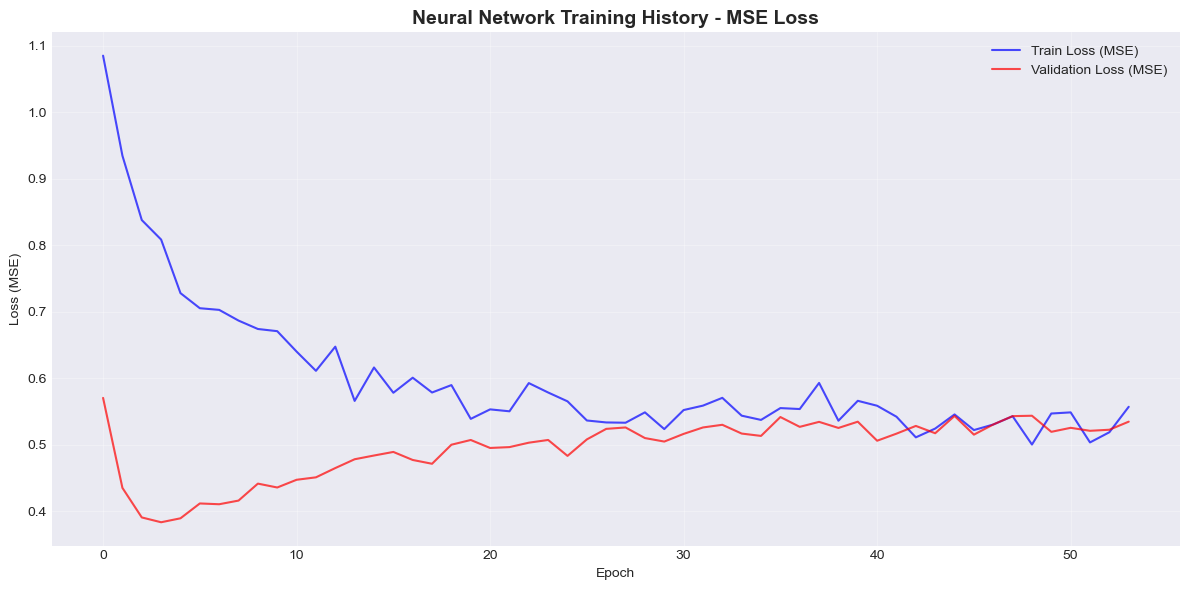


Neural Network training complete!


In [74]:
# ============================================================================
# NEURAL NETWORK MODEL (PyTorch)
# ============================================================================
print("=" * 70)
print("NEURAL NETWORK MODEL TRAINING")
print("=" * 70)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Standardize features for neural network
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Reshape y for scaler (needs 2D)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

# Define neural network architecture
class VolatilityNet(nn.Module):
    """
    Shallow Multi-Layer Perceptron (MLP) for volatility forecasting.
    Used as a nonlinear benchmark to compare against linear models.
    Architecture: Input -> [256, 128, 64, 32, 16] -> Output (rv_logdiff prediction)
    """
    def __init__(self, input_dim, hidden_dims=[256, 128, 64, 32, 16], dropout_rate=0.3):
        super(VolatilityNet, self).__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze()


# ============================================================================
# ============================================================================
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

def compute_metrics(y_true, y_pred, y_true_rv_diff=None, y_pred_rv_diff=None):
    """
    Compute comprehensive metrics for RV change forecasting.
    
    Parameters:
    - y_true: true rv_logdiff values
    - y_pred: predicted rv_logdiff values
    - y_true_rv_diff: true rv_diff values (optional, for rv_diff metrics)
    - y_pred_rv_diff: predicted rv_diff values (optional, for rv_diff metrics)
    
    Returns:
    - Dictionary of metrics
    """
    metrics = {}
    
    # RMSE and MAE on rv_logdiff
    metrics['rmse_logdiff'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['mae_logdiff'] = mean_absolute_error(y_true, y_pred)
    
    # RMSE and MAE on rv_diff (if provided)
    if y_true_rv_diff is not None and y_pred_rv_diff is not None:
        metrics['rmse_diff'] = np.sqrt(mean_squared_error(y_true_rv_diff, y_pred_rv_diff))
        metrics['mae_diff'] = mean_absolute_error(y_true_rv_diff, y_pred_rv_diff)
    
    # Directional accuracy on rv_diff
    if y_true_rv_diff is not None and y_pred_rv_diff is not None:
        # Exclude zeros (treat as separate class)
        mask = (y_true_rv_diff != 0) & (y_pred_rv_diff != 0)
        if mask.sum() > 0:
            true_sign = np.sign(y_true_rv_diff[mask])
            pred_sign = np.sign(y_pred_rv_diff[mask])
            metrics['directional_accuracy'] = np.mean(true_sign == pred_sign)
        else:
            metrics['directional_accuracy'] = np.nan
    
    # Pearson correlation
    if len(y_true) > 1:
        corr, pval = pearsonr(y_true, y_pred)
        metrics['correlation'] = corr
        metrics['correlation_pval'] = pval
    else:
        metrics['correlation'] = np.nan
        metrics['correlation_pval'] = np.nan
    
    return metrics


input_dim = X_train_scaled.shape[1]
nn_model = VolatilityNet(input_dim=input_dim, hidden_dims=[128, 64, 32, 16], dropout_rate=0.3).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training parameters
num_epochs = NN_EPOCHS
batch_size = NN_BATCH_SIZE
patience = NN_PATIENCE
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
best_epoch = 0

# Training loop
print(f"\nTraining Neural Network for {num_epochs} epochs...")
print(f"Input dimension: {input_dim}")
print(f"Training samples: {len(X_train_tensor)}")
print(f"Validation samples: {len(X_val_tensor)}")
print(f"Test samples: {len(X_test_tensor)}")

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    nn_model.train()
    train_loss = 0.0
    num_batches = 0
    
    # Mini-batch training
    # Use DataLoader for efficient batching
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(nn_model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        train_loss += loss.item()
        num_batches += 1
    
    avg_train_loss = train_loss / num_batches if num_batches > 0 else train_loss
    train_losses.append(avg_train_loss)
    
    # Validation phase
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_losses.append(val_loss)
        
        
        train_outputs = nn_model(X_train_tensor)
    
    # Learning rate scheduling (still based on MSE loss)
    scheduler.step(val_loss)
    
    # Early stopping based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = nn_model.state_dict().copy()
        best_epoch = epoch + 1
    else:
        patience_counter += 1
    
    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}, Best Epoch: {best_epoch}")
    
    # Early stopping
    if patience_counter >= patience:
        break

# Load best model
if best_model_state is not None:
    nn_model.load_state_dict(best_model_state)

# Make predictions
nn_model.eval()
with torch.no_grad():
    nn_pred_train_scaled = nn_model(X_train_tensor).cpu().numpy()
    nn_pred_val_scaled = nn_model(X_val_tensor).cpu().numpy()
    nn_pred_test_scaled = nn_model(X_test_tensor).cpu().numpy()

# Inverse transform predictions
nn_pred_train = scaler_y.inverse_transform(nn_pred_train_scaled.reshape(-1, 1)).flatten()
nn_pred_val = scaler_y.inverse_transform(nn_pred_val_scaled.reshape(-1, 1)).flatten()
nn_pred_test = scaler_y.inverse_transform(nn_pred_test_scaled.reshape(-1, 1)).flatten()

# Calculate metrics
nn_r2_train = r2_score(y_train, nn_pred_train)
nn_r2_val = r2_score(y_val, nn_pred_val)
nn_r2_test = r2_score(y_test, nn_pred_test)

nn_rmse_train = np.sqrt(mean_squared_error(y_train, nn_pred_train))
nn_rmse_val = np.sqrt(mean_squared_error(y_val, nn_pred_val))
nn_rmse_test = np.sqrt(mean_squared_error(y_test, nn_pred_test))

print("\n" + "=" * 70)
print("NEURAL NETWORK MODEL PERFORMANCE")
print("=" * 70)
print(f"\nTrain Set:")
print(f"  R²: {nn_r2_train:.4f}")
print(f"  RMSE: {nn_rmse_train:.6f}")
print(f"\nValidation Set:")
print(f"  R²: {nn_r2_val:.4f}")
print(f"  RMSE: {nn_rmse_val:.6f}")
print(f"\nTest Set:")
print(f"  R²: {nn_r2_test:.4f}")
print(f"  RMSE: {nn_rmse_test:.6f}")
print("=" * 70)

# Plot training history
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot MSE Loss
ax.plot(train_losses, label='Train Loss (MSE)', alpha=0.7, color='blue')
ax.plot(val_losses, label='Validation Loss (MSE)', alpha=0.7, color='red')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Neural Network Training History - MSE Loss', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('nn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nNeural Network training complete!")


BENCHMARK MODELS & COMPREHENSIVE EVALUATION

HAR-RV Model
HAR-RV Model Summary:
  Train R²: 0.0398
  Val R²: 0.0133
  Test R²: 0.0510

HAR-X Model (HAR + lagged returns)
HAR-X Model Summary:
  Train R²: 0.0489
  Val R²: 0.0032
  Test R²: 0.0672

Forecast Combination (Ensemble)
Test set sizes:
  RandomForest/Baseline: 452
  HAR-RV: 430
  HAR-X: 427
  Common index: 427

Ensemble (Simple Average) Test R²: 0.3173

COMPREHENSIVE MODEL COMPARISON (Test Set)

          Model  RMSE_logdiff  MAE_logdiff  RMSE_diff  MAE_diff  Directional_Acc  Correlation       R²
   RandomForest      0.336087     0.260667   0.067569  0.038188         0.730679     0.632851 0.378389
Baseline Linear      0.349065     0.267968   0.069387  0.039308         0.758782     0.581479 0.329455
         HAR-RV      0.415287     0.324204   0.077915  0.047098         0.580796     0.244184 0.050900
          HAR-X      0.411698     0.320587   0.075754  0.046381         0.601874     0.298917 0.067234
 Neural Network      0.35193

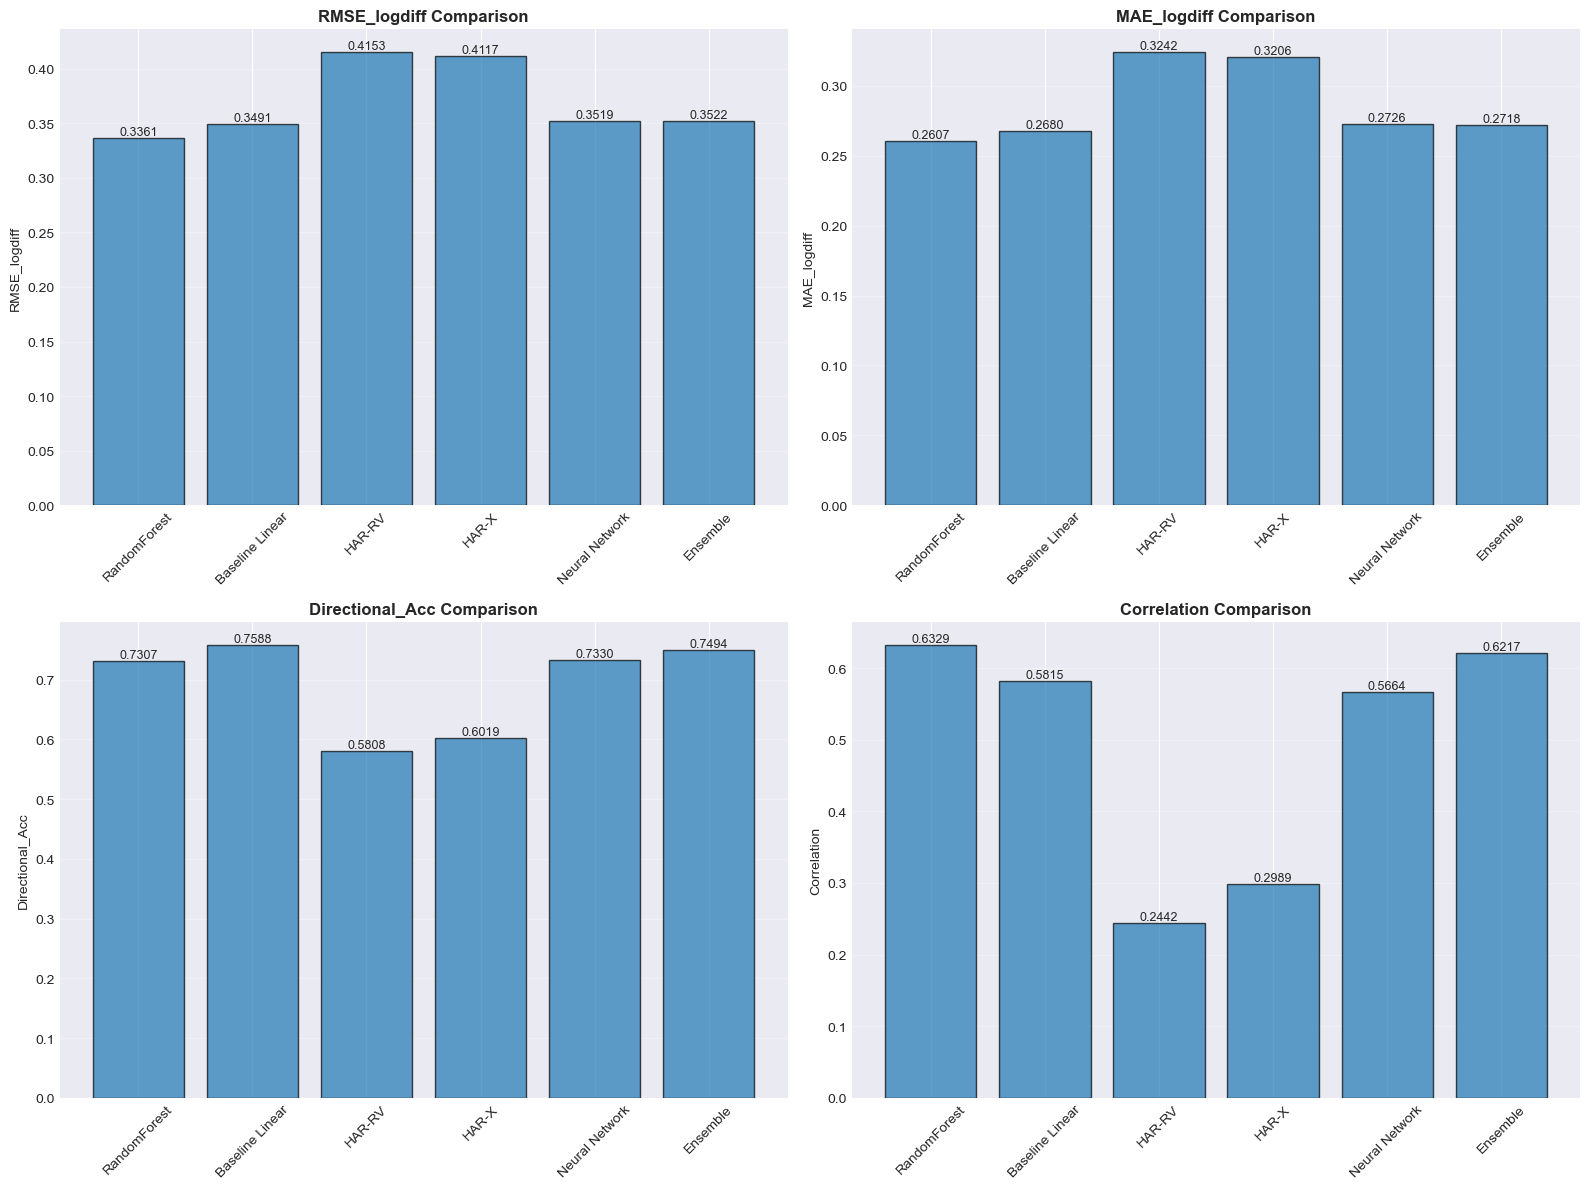

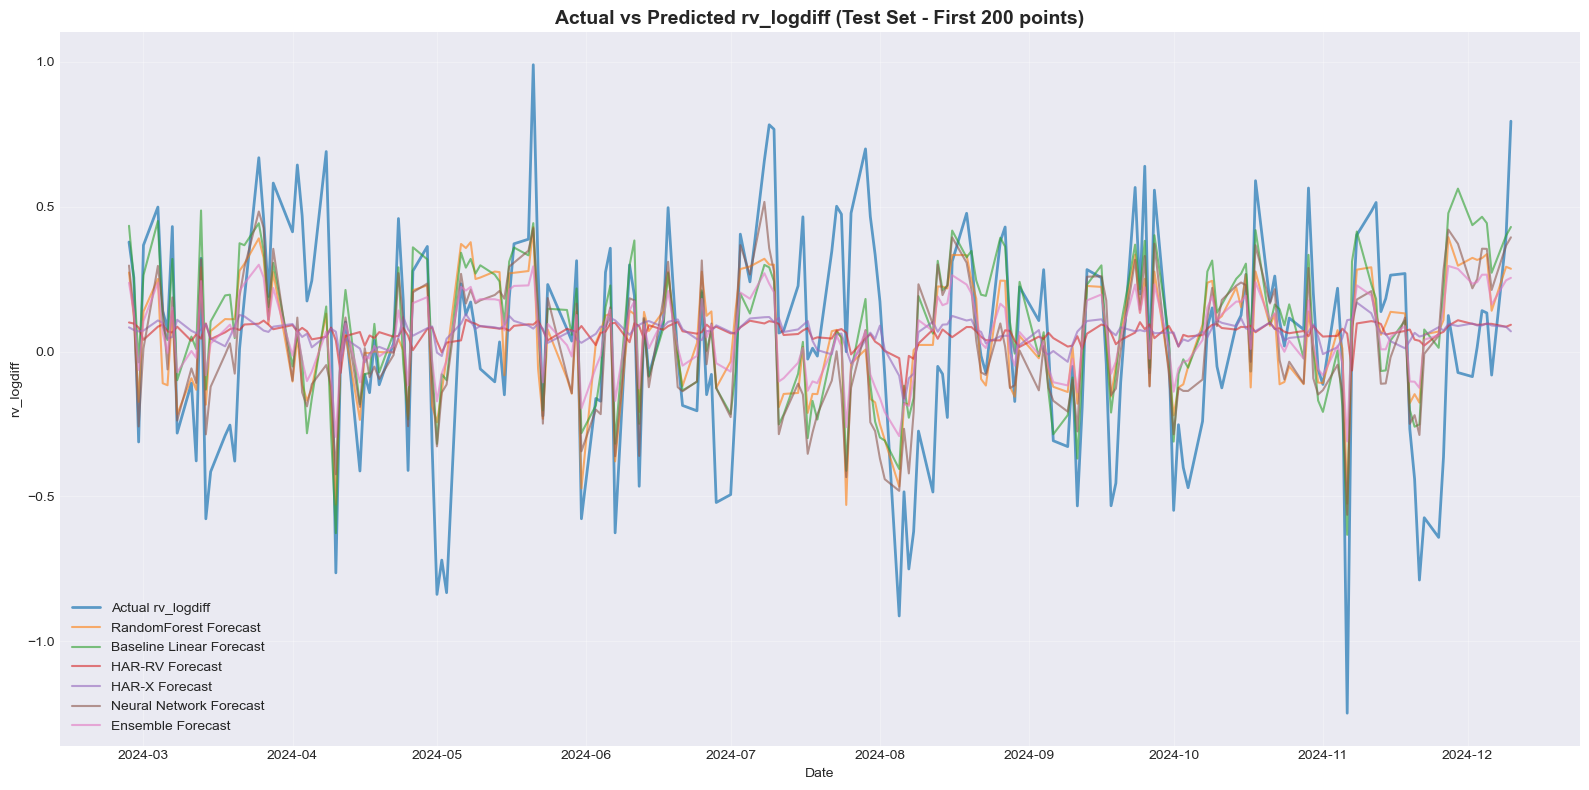


COMPARISON SUMMARY

RandomForest vs Baseline Linear:
  R² improvement: 0.0489
  RMSE_logdiff reduction: 0.0130

RandomForest vs HAR-RV:
  R² improvement: 0.3275
  RMSE_logdiff reduction: 0.0792

Best Model (by R²): RandomForest
Best Model (by RMSE_logdiff): RandomForest
Best Model (by Directional_Acc): Baseline Linear


In [ ]:
# ============================================================================
# BENCHMARK MODELS & COMPREHENSIVE EVALUATION
# ============================================================================

print("=" * 70)
print("BENCHMARK MODELS & COMPREHENSIVE EVALUATION")
print("=" * 70)


print("\n" + "=" * 70)
print("HAR-RV Model")
print("=" * 70)

def create_har_features(df_features, target_col):
    """Create HAR-RV features: daily, weekly (5-day), monthly (22-day) RV lags"""
    har_features = pd.DataFrame(index=df_features.index)
    
    # Daily RV lag (t-1)
    har_features['rv_daily'] = df_features['rv_today'].shift(1)
    
    # Weekly RV (5-day average, lagged)
    har_features['rv_weekly'] = df_features['rv_today'].shift(1).rolling(window=5, min_periods=5).mean()
    
    # Monthly RV (22-day average, lagged)
    har_features['rv_monthly'] = df_features['rv_today'].shift(1).rolling(window=22, min_periods=22).mean()
    
    # Align with target
    har_features = har_features.loc[df_features.index]
    target = df_features[target_col]
    
    # Common index
    common_idx = har_features.index.intersection(target.index)
    har_features = har_features.loc[common_idx]
    target = target.loc[common_idx]
    
    # Drop NaNs
    mask = ~(har_features.isna().any(axis=1) | target.isna())
    har_features = har_features[mask]
    target = target[mask]
    
    return har_features, target

# Create HAR features for train/val/test - use rv_logdiff as target
har_X_train, har_y_train = create_har_features(train_data, f'rv_logdiff_{FORECAST_TARGET}d')
har_X_val, har_y_val = create_har_features(val_data, f'rv_logdiff_{FORECAST_TARGET}d')
har_X_test, har_y_test = create_har_features(test_data, f'rv_logdiff_{FORECAST_TARGET}d')

# Fit HAR-RV model
har_model = OLS(har_y_train, add_constant(har_X_train)).fit()
har_pred_train = har_model.predict(add_constant(har_X_train))
har_pred_val = har_model.predict(add_constant(har_X_val))
har_pred_test = har_model.predict(add_constant(har_X_test))

print(f"HAR-RV Model Summary:")
print(f"  Train R²: {r2_score(har_y_train, har_pred_train):.4f}")
print(f"  Val R²: {r2_score(har_y_val, har_pred_val):.4f}")
print(f"  Test R²: {r2_score(har_y_test, har_pred_test):.4f}")

# ============================================================================
# HAR-X Model (HAR with additional predictors)
# ============================================================================
print("\n" + "=" * 70)
print("HAR-X Model (HAR + lagged returns)")
print("=" * 70)

def create_harx_features(df_features, target_col, ret_15m_series):
    """Create HAR-X features: HAR-RV + lagged returns"""
    harx_features, target = create_har_features(df_features, target_col)
    
    # Add lagged returns (need to compute daily returns)
    daily_returns = ret_15m_series.groupby(pd.Grouper(freq='D')).sum()
    daily_returns = daily_returns[daily_returns.index.isin(df_features.index)]
    
    # Align returns with features
    common_idx = harx_features.index.intersection(daily_returns.index)
    harx_features = harx_features.loc[common_idx]
    target = target.loc[common_idx]
    daily_returns = daily_returns.loc[common_idx]
    
    # Lagged returns (t-1, t-2, t-3)
    harx_features['ret_lag1'] = daily_returns.shift(1).loc[harx_features.index]
    harx_features['ret_lag2'] = daily_returns.shift(2).loc[harx_features.index]
    harx_features['ret_lag3'] = daily_returns.shift(3).loc[harx_features.index]
    
    # Drop NaNs
    mask = ~(harx_features.isna().any(axis=1) | target.isna())
    harx_features = harx_features[mask]
    target = target[mask]
    
    return harx_features, target

# Create HAR-X features - use rv_logdiff as target
harx_X_train, harx_y_train = create_harx_features(train_data, f'rv_logdiff_{FORECAST_TARGET}d', ret_15m)
harx_X_val, harx_y_val = create_harx_features(val_data, f'rv_logdiff_{FORECAST_TARGET}d', ret_15m)
harx_X_test, harx_y_test = create_harx_features(test_data, f'rv_logdiff_{FORECAST_TARGET}d', ret_15m)

# Fit HAR-X model
harx_model = OLS(harx_y_train, add_constant(harx_X_train)).fit()
harx_pred_train = harx_model.predict(add_constant(harx_X_train))
harx_pred_val = harx_model.predict(add_constant(harx_X_val))
harx_pred_test = harx_model.predict(add_constant(harx_X_test))

print(f"HAR-X Model Summary:")
print(f"  Train R²: {r2_score(harx_y_train, harx_pred_train):.4f}")
print(f"  Val R²: {r2_score(harx_y_val, harx_pred_val):.4f}")
print(f"  Test R²: {r2_score(harx_y_test, harx_pred_test):.4f}")

# ============================================================================
# FORECAST COMBINATION (Ensemble)
# ============================================================================
print("\n" + "=" * 70)
print("Forecast Combination (Ensemble)")
print("=" * 70)

# Get predictions from all models on common test set
# Align all predictions to common index
# Find the intersection of all model indices (they may have different indices due to NaN handling)
rf_test_idx = test_data.index
har_test_idx = har_y_test.index
harx_test_idx = harx_y_test.index

# Find common index across all models
common_test_idx = rf_test_idx.intersection(har_test_idx).intersection(harx_test_idx)

print(f"Test set sizes:")
print(f"  RandomForest/Baseline: {len(rf_test_idx)}")
print(f"  HAR-RV: {len(har_test_idx)}")
print(f"  HAR-X: {len(harx_test_idx)}")
print(f"  Common index: {len(common_test_idx)}")

if len(common_test_idx) > 0:
    # RandomForest predictions
    rf_pred_test_series = pd.Series(model.predict(X_test), index=rf_test_idx)
    rf_pred_test_aligned = rf_pred_test_series.loc[common_test_idx].values
    
    # Baseline Linear predictions
    baseline_pred_test_series = pd.Series(baseline_model.predict(X_test), index=rf_test_idx)
    baseline_pred_test_aligned = baseline_pred_test_series.loc[common_test_idx].values
    
    # HAR predictions (already a Series with index)
    har_pred_test_aligned = har_pred_test.loc[common_test_idx].values
    
    # HAR-X predictions (already a Series with index)
    harx_pred_test_aligned = harx_pred_test.loc[common_test_idx].values
    
    # Neural Network predictions - align to common test index
    nn_pred_test_series = pd.Series(nn_pred_test, index=rf_test_idx)
    nn_pred_test_aligned = nn_pred_test_series.loc[common_test_idx].values
    
    # Get aligned target values
    ensemble_y_test = har_y_test.loc[common_test_idx].values
    
    # Simple average ensemble (all already aligned to common_test_idx)
    # Include Neural Network in ensemble
    ensemble_pred_test = (
        rf_pred_test_aligned +
        baseline_pred_test_aligned +
        har_pred_test_aligned +
        harx_pred_test_aligned +
        nn_pred_test_aligned
    ) / 5
    
    print(f"\nEnsemble (Simple Average) Test R²: {r2_score(ensemble_y_test, ensemble_pred_test):.4f}")
else:
    print("\nWARNING: No common index found between models. Using fallback alignment.")
    # Fallback: use minimum length
    min_len = min(len(rf_test_idx), len(har_test_idx), len(harx_test_idx), len(nn_pred_test))
    ensemble_pred_test = (
        model.predict(X_test)[:min_len] +
        baseline_model.predict(X_test)[:min_len] +
        har_pred_test.values[:min_len] +
        harx_pred_test.values[:min_len] +
        nn_pred_test[:min_len]
    ) / 5
    ensemble_y_test = har_y_test.values[:min_len]
    common_test_idx = har_test_idx[:min_len]

# ============================================================================
# COMPREHENSIVE MODEL COMPARISON
# ============================================================================
print("\n" + "=" * 70)
print("COMPREHENSIVE MODEL COMPARISON (Test Set)")
print("=" * 70)

# Align all predictions to common test index (already done above)
# Use the aligned predictions we computed
rf_pred_aligned = rf_pred_test_aligned
baseline_pred_aligned = baseline_pred_test_aligned
har_pred_aligned = har_pred_test_aligned
harx_pred_aligned = harx_pred_test_aligned
y_test_aligned = ensemble_y_test

# Neural Network predictions (already aligned above if common_test_idx exists, otherwise use original)
if len(common_test_idx) > 0:
    nn_pred_aligned = nn_pred_test_aligned
else:
    nn_pred_aligned = nn_pred_test

# Compute metrics for all models
models_results = {
    'RandomForest': rf_pred_aligned,
    'Baseline Linear': baseline_pred_aligned,
    'HAR-RV': har_pred_aligned,
    'HAR-X': harx_pred_aligned,
    'Neural Network': nn_pred_aligned,
    'Ensemble': ensemble_pred_test
}

results_table = []
eps = 1e-12  # For log conversion
for model_name, pred in models_results.items():
    mse = mean_squared_error(y_test_aligned, pred)
    rmse = np.sqrt(mse)
    # Compute comprehensive metrics
    # Convert predictions back to rv_diff for evaluation
    # Note: predictions are in rv_logdiff space
    # For rv_diff metrics, we need to convert: rv_diff = exp(rv_logdiff + log(rv_today)) - rv_today
    # But for now, compute metrics on rv_logdiff directly
    rmse_logdiff = np.sqrt(mean_squared_error(y_test_aligned, pred))
    mae_logdiff = mean_absolute_error(y_test_aligned, pred)
    
    # Convert predictions back to rv_diff for rv_diff metrics
    # pred is in rv_logdiff space, need to convert to rv_diff
    # rv_logdiff = log(rv_fwd) - log(rv_today), so rv_fwd = exp(rv_logdiff + log(rv_today))
    # rv_diff = rv_fwd - rv_today = exp(rv_logdiff + log(rv_today)) - rv_today
    test_rv_today = test_data['rv_today'].loc[common_test_idx].values if len(common_test_idx) > 0 else test_data['rv_today'].values[:len(pred)]
    pred_rv_fwd = np.exp(pred + np.log(test_rv_today + eps)) - eps
    pred_rv_diff = pred_rv_fwd - test_rv_today
    
    # Get actual rv_diff for comparison
    y_test_rv_diff_aligned = y_test_rv_diff[:len(pred)] if len(common_test_idx) == 0 else test_data[f'rv_diff_{FORECAST_TARGET}d'].loc[common_test_idx].values
    
    # Use compute_metrics function
    metrics = compute_metrics(y_test_aligned, pred, y_test_rv_diff_aligned, pred_rv_diff)
    
    # Directional accuracy (on sign of rv_diff change)
    true_sign = np.sign(y_test_rv_diff_aligned)
    pred_sign = np.sign(pred_rv_diff)
    # Exclude zeros
    mask = (true_sign != 0) & (pred_sign != 0)
    if mask.sum() > 0:
        directional_acc = np.mean(true_sign[mask] == pred_sign[mask])
    else:
        directional_acc = np.nan
    
    r2 = r2_score(y_test_aligned, pred)
    
    results_table.append({
        'Model': model_name,
        'RMSE_logdiff': metrics['rmse_logdiff'],
        'MAE_logdiff': metrics['mae_logdiff'],
        'RMSE_diff': metrics.get('rmse_diff', np.nan),
        'MAE_diff': metrics.get('mae_diff', np.nan),
        'Directional_Acc': directional_acc,
        'Correlation': metrics['correlation'],
        'R²': r2
    })

results_df = pd.DataFrame(results_table)
print("\n" + results_df.to_string(index=False))

# ============================================================================
# COMPARISON PLOTS
# ============================================================================
print("\n" + "=" * 70)
print("Generating Comparison Plots...")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define metrics to plot (matching column names in results_df)
metrics = ['RMSE_logdiff', 'MAE_logdiff', 'Directional_Acc', 'Correlation']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = results_df[metric].values
    bars = ax.bar(results_df['Model'], values, alpha=0.7, edgecolor='black')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

# Time series plot: Actual vs Predictions
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(common_test_idx[:200] if len(common_test_idx) > 200 else common_test_idx, 
        y_test_aligned[:200] if len(y_test_aligned) > 200 else y_test_aligned,
        label='Actual rv_logdiff', linewidth=2, alpha=0.7)

for model_name, pred in models_results.items():
    pred_values = pred[:200] if len(pred) > 200 else pred
    ax.plot(common_test_idx[:200] if len(common_test_idx) > 200 else common_test_idx,
            pred_values, label=f'{model_name} Forecast', alpha=0.6, linewidth=1.5)

ax.set_title('Actual vs Predicted rv_logdiff (Test Set - First 200 points)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('rv_logdiff')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_forecasts_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "=" * 70)
print("COMPARISON SUMMARY")
print("=" * 70)
print(f"\nRandomForest vs Baseline Linear:")
print(f"  R² improvement: {results_df[results_df['Model']=='RandomForest']['R²'].values[0] - results_df[results_df['Model']=='Baseline Linear']['R²'].values[0]:.4f}")
print(f"  RMSE_logdiff reduction: {results_df[results_df['Model']=='Baseline Linear']['RMSE_logdiff'].values[0] - results_df[results_df['Model']=='RandomForest']['RMSE_logdiff'].values[0]:.4f}")

print(f"\nRandomForest vs HAR-RV:")
print(f"  R² improvement: {results_df[results_df['Model']=='RandomForest']['R²'].values[0] - results_df[results_df['Model']=='HAR-RV']['R²'].values[0]:.4f}")
print(f"  RMSE_logdiff reduction: {results_df[results_df['Model']=='HAR-RV']['RMSE_logdiff'].values[0] - results_df[results_df['Model']=='RandomForest']['RMSE_logdiff'].values[0]:.4f}")

print(f"\nBest Model (by R²): {results_df.loc[results_df['R²'].idxmax(), 'Model']}")
print(f"Best Model (by RMSE_logdiff): {results_df.loc[results_df['RMSE_logdiff'].idxmin(), 'Model']}")
print(f"Best Model (by Directional_Acc): {results_df.loc[results_df['Directional_Acc'].idxmax(), 'Model']}")

print("=" * 70)


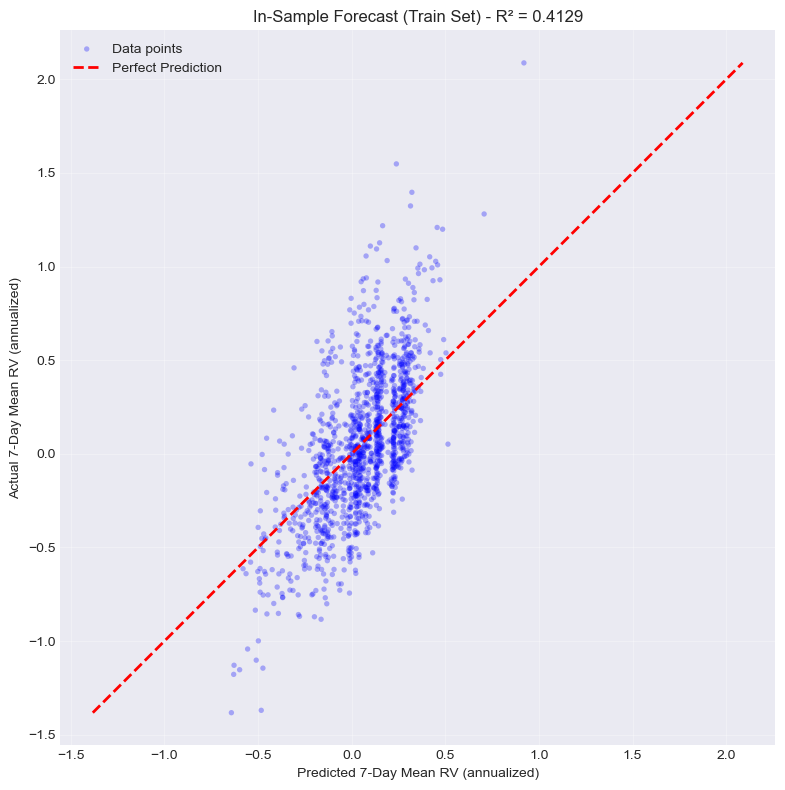

In [76]:
# Plot 1: In-sample (train set) - Predicted vs Actual scatter
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter: X = predicted rv_logdiff, Y = actual rv_logdiff
ax.scatter(y_train_pred, y_train, alpha=0.3, s=15, color='blue', edgecolors='none', label='Data points')

# Perfect prediction line
min_val = min(y_train_pred.min(), y_train.min())
max_val = max(y_train_pred.max(), y_train.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_xlabel(f'Predicted {FORECAST_TARGET}-Day Mean RV (annualized)')
ax.set_ylabel(f'Actual {FORECAST_TARGET}-Day Mean RV (annualized)')
ax.set_title(f'In-Sample Forecast (Train Set) - R² = {r2_train:.4f}')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


MODEL SELECTOR & ENHANCED ANALYSIS

Selected models for plotting: RandomForest, Baseline Linear, HAR-RV, HAR-X, Neural Network, Ensemble
Total models selected: 6

Generating Enhanced Comparison Plots (Selected Models Only)


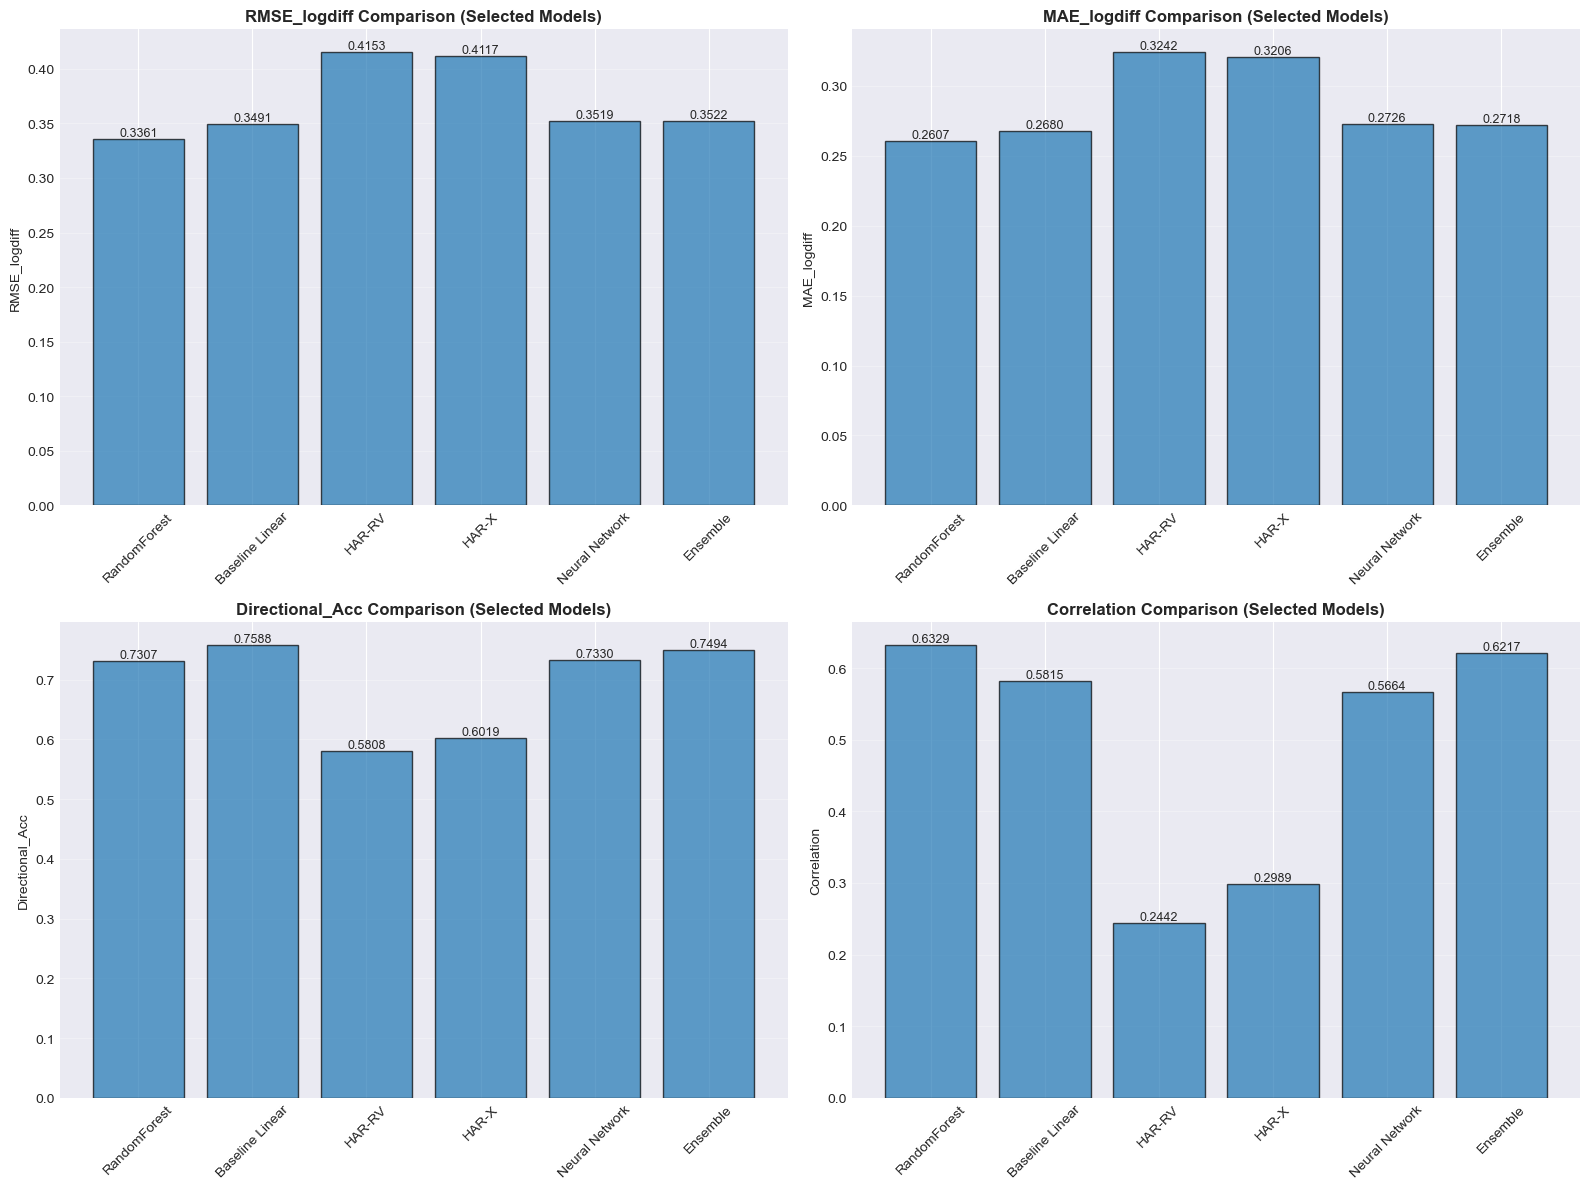

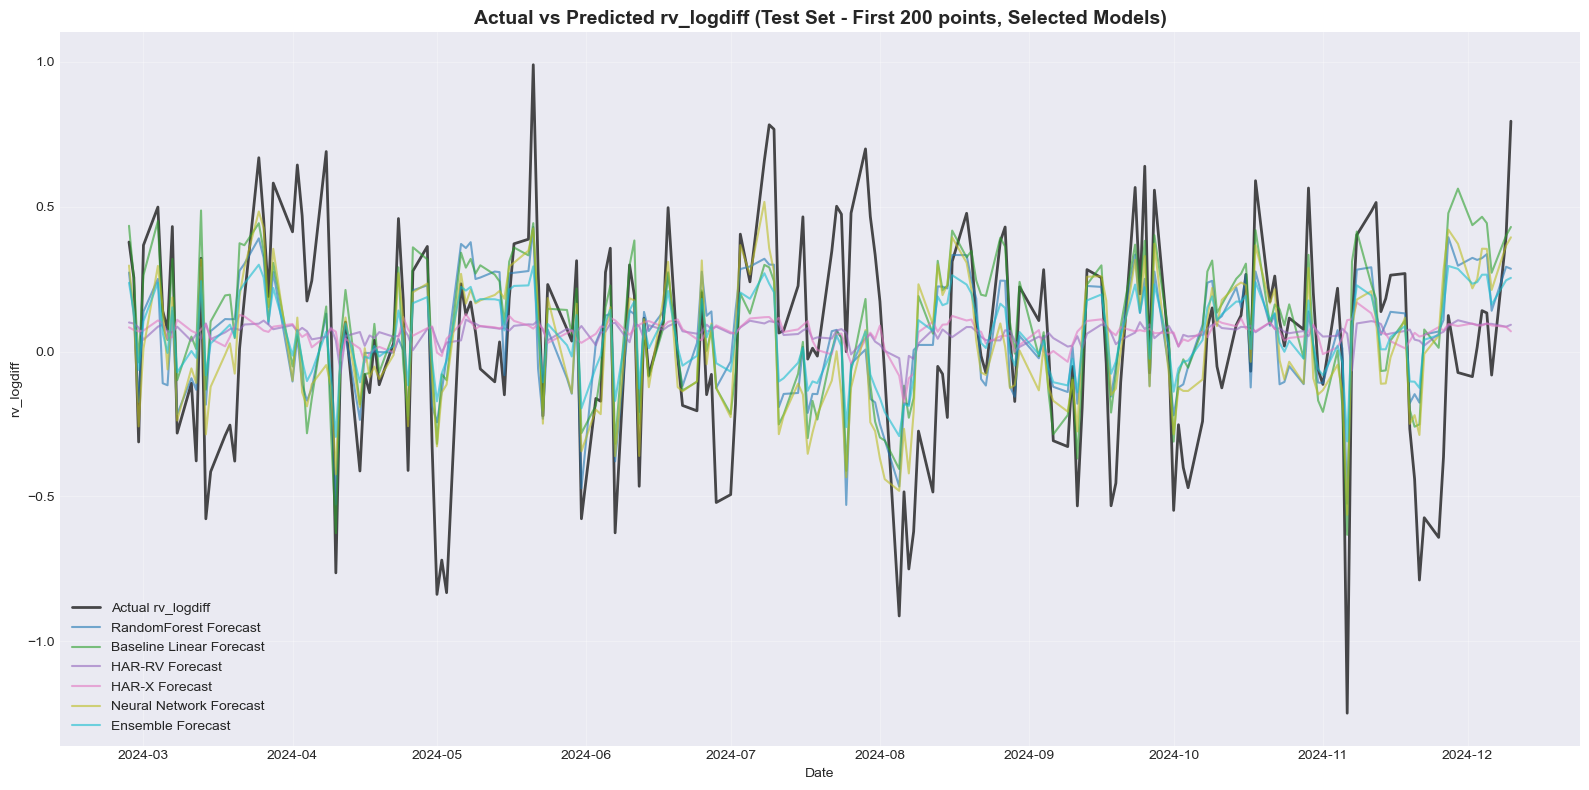


RV QUANTILE ANALYSIS: Model Performance by Volatility Regime

RV Quantile Thresholds (computed on TRAIN set, applied to TEST):
  Low Vol (≤33rd percentile): ≤ 0.0855
  Medium Vol (33rd-67th percentile): 0.0855 - 0.1436
  High Vol (>67th percentile): > 0.1436

Sample sizes per quantile:
  Low Vol: 73 samples
  Medium Vol: 237 samples
  High Vol: 117 samples

MODEL PERFORMANCE BY VOLATILITY REGIME

RandomForest:
  Low Vol:
    R²: -0.1657
    RMSE: 0.328622
    Hit Rate: 0.6027
  Medium Vol:
    R²: 0.5547
    RMSE: 0.271233
    Hit Rate: 0.7975
  High Vol:
    R²: 0.1598
    RMSE: 0.442533
    Hit Rate: 0.6752

Baseline Linear:
  Low Vol:
    R²: -0.5400
    RMSE: 0.377722
    Hit Rate: 0.5890
  Medium Vol:
    R²: 0.5695
    RMSE: 0.266682
    Hit Rate: 0.8354
  High Vol:
    R²: 0.0921
    RMSE: 0.460008
    Hit Rate: 0.7094

HAR-RV:
  Low Vol:
    R²: -0.4469
    RMSE: 0.366119
    Hit Rate: 0.3836
  Medium Vol:
    R²: 0.0558
    RMSE: 0.394972
    Hit Rate: 0.5865
  High Vol:
    

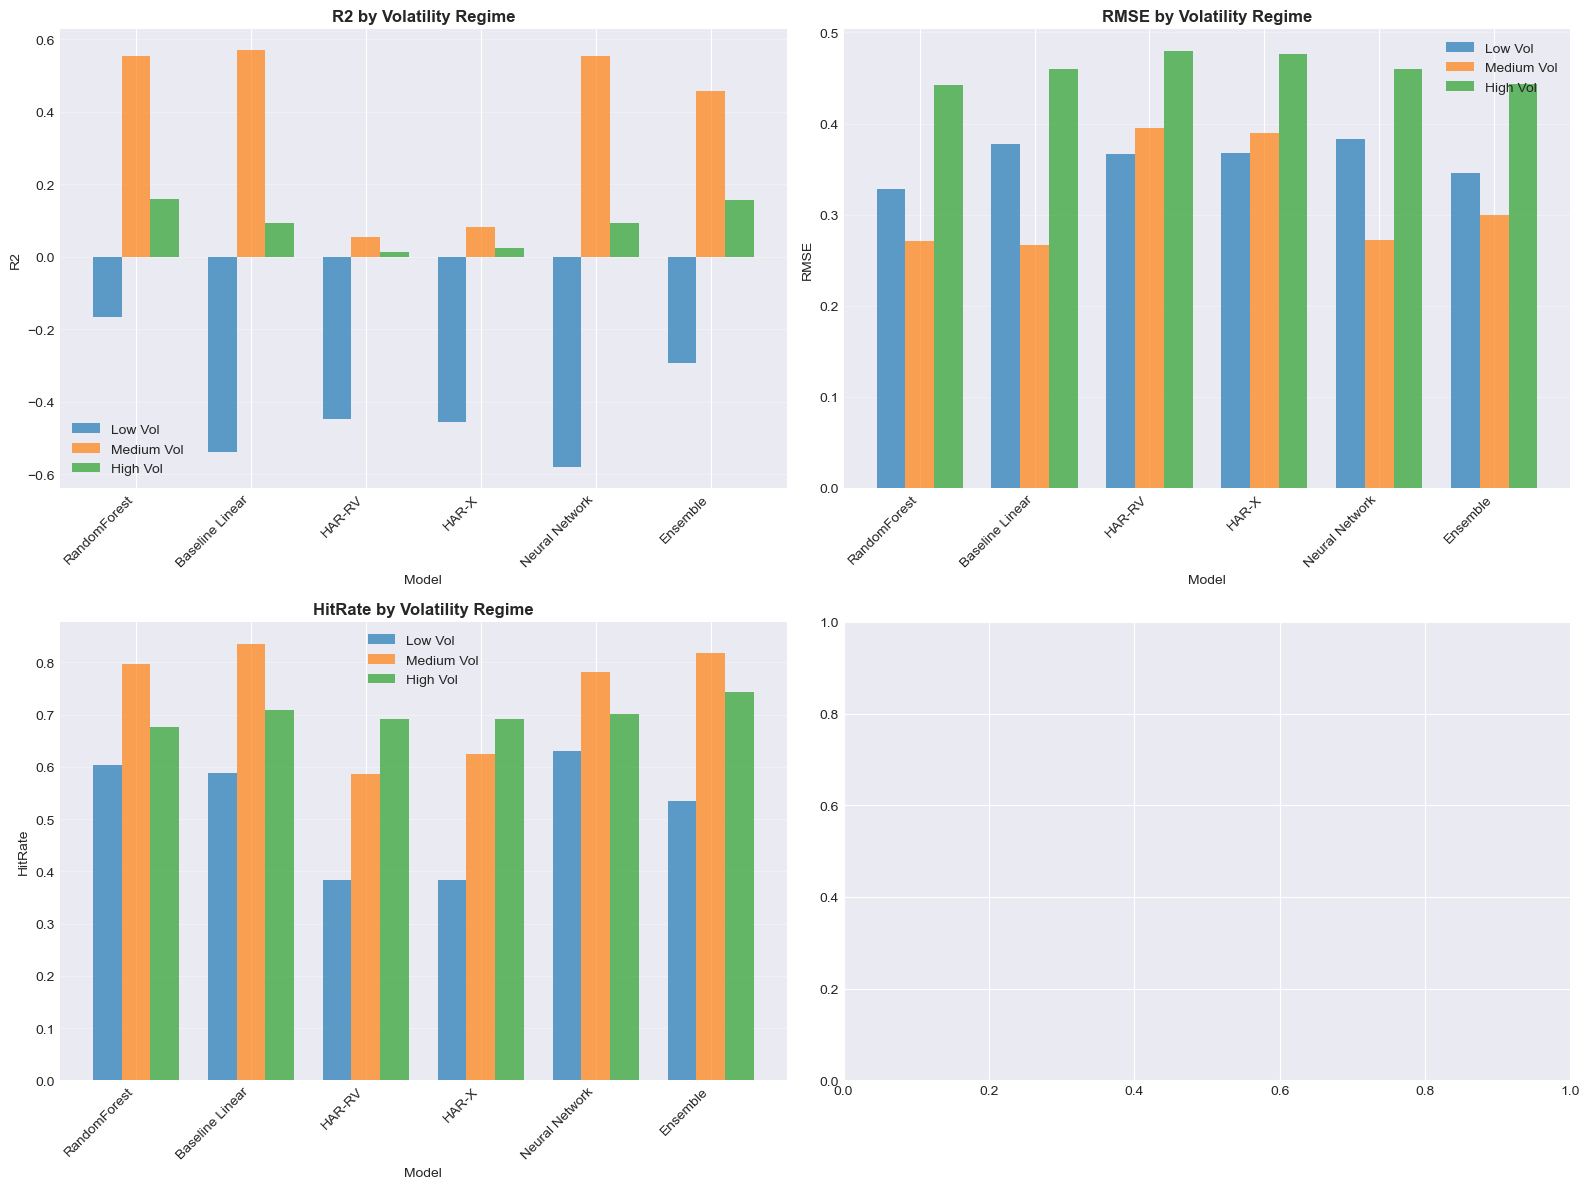


RANDOMFOREST MODEL: Feature Importance

Top 30 Most Important Features:
                     feature  importance
            past_mean_diff_7    0.431942
     rv_today_ratio_21d_mean    0.188134
                 rv_change_1    0.068266
rv_today_ratio_21d_mean_rank    0.065746
              autocorr_lag10    0.050482
         sarima_residual_std    0.040776
                 rv_change_5    0.030654
                 past_mean_7    0.029052
               rv_corr_ratio    0.017306
             sarima_forecast    0.014398
                     rv_lag5    0.008652
                     rv_lag1    0.007880
               autocorr_lag5    0.007553
                     rv_lag2    0.006229
        fourier_total_energy    0.004829
             rv_ratio_2d_14d    0.004778
           rv_vol_corr_ratio    0.003094
           rv_ratio_20d_rank    0.002992
        fourier_dominant_amp    0.002973
               autocorr_lag3    0.002357
          fourier_second_amp    0.002084
       fourier_dominant_f

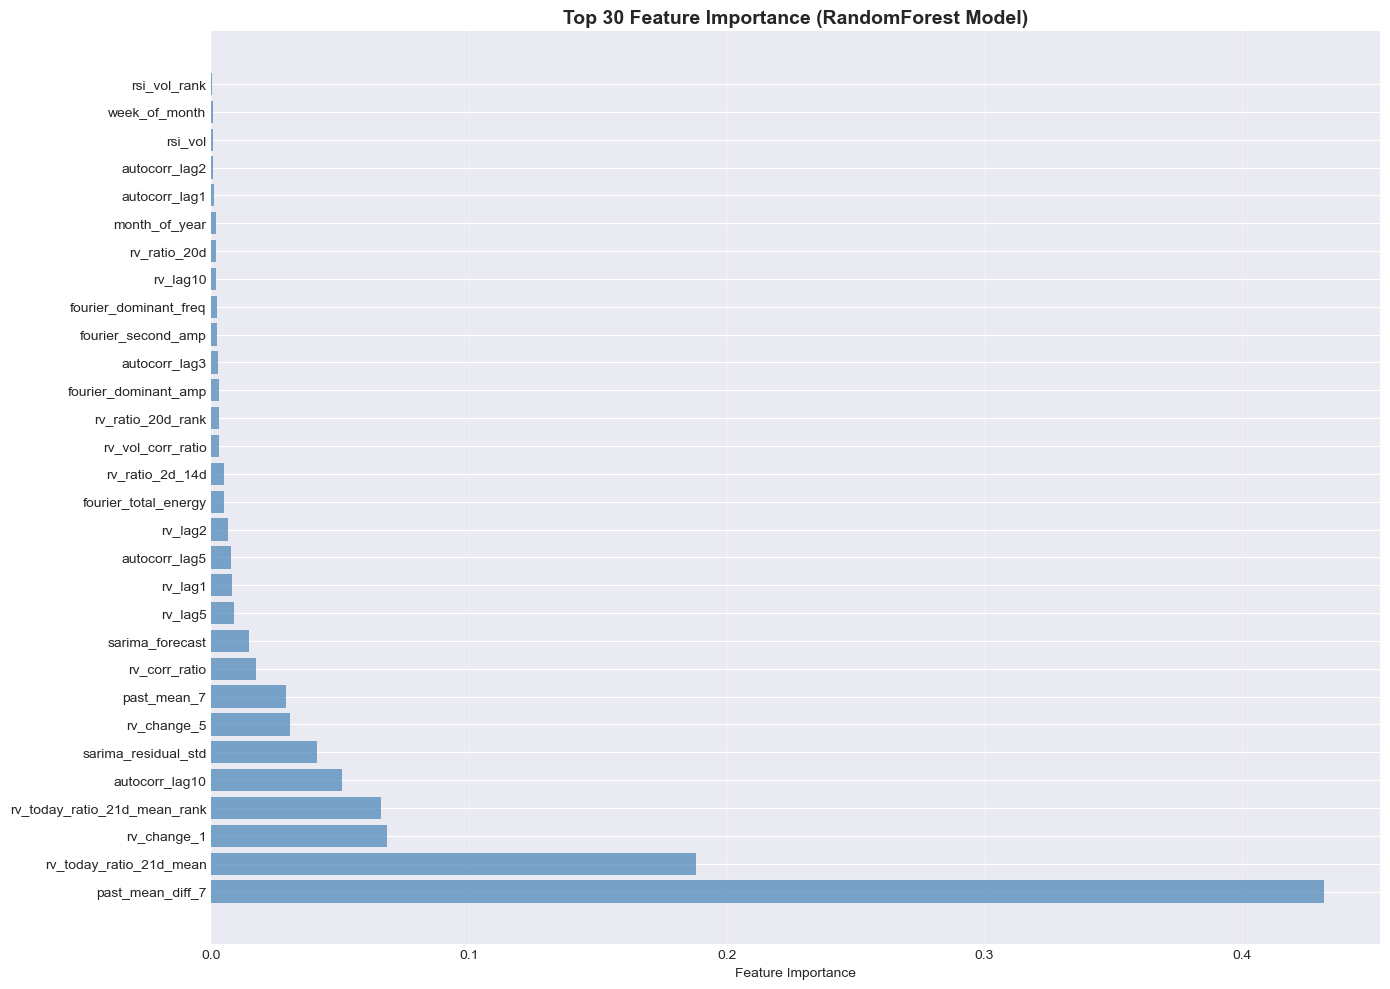


BASELINE LINEAR MODEL: Feature Importance

Linear Model Intercept: 0.416109

Top 30 Most Important Features (by absolute coefficient):
                     feature  coefficient  abs_coefficient
       fourier_dominant_freq     1.104255         1.104255
                     rv_lag2    -0.605070         0.605070
rv_today_ratio_21d_mean_rank    -0.567176         0.567176
                 past_mean_7    -0.372028         0.372028
                 rv_change_1    -0.360475         0.360475
                    rv_lag10    -0.324537         0.324537
               rv_corr_ratio    -0.276438         0.276438
         sarima_residual_std    -0.223229         0.223229
     rv_today_ratio_21d_mean    -0.222799         0.222799
               autocorr_lag1     0.208163         0.208163
             sarima_forecast    -0.172568         0.172568
            past_mean_diff_7    -0.134821         0.134821
                 rv_change_5    -0.130590         0.130590
                     rv_lag1     0.123

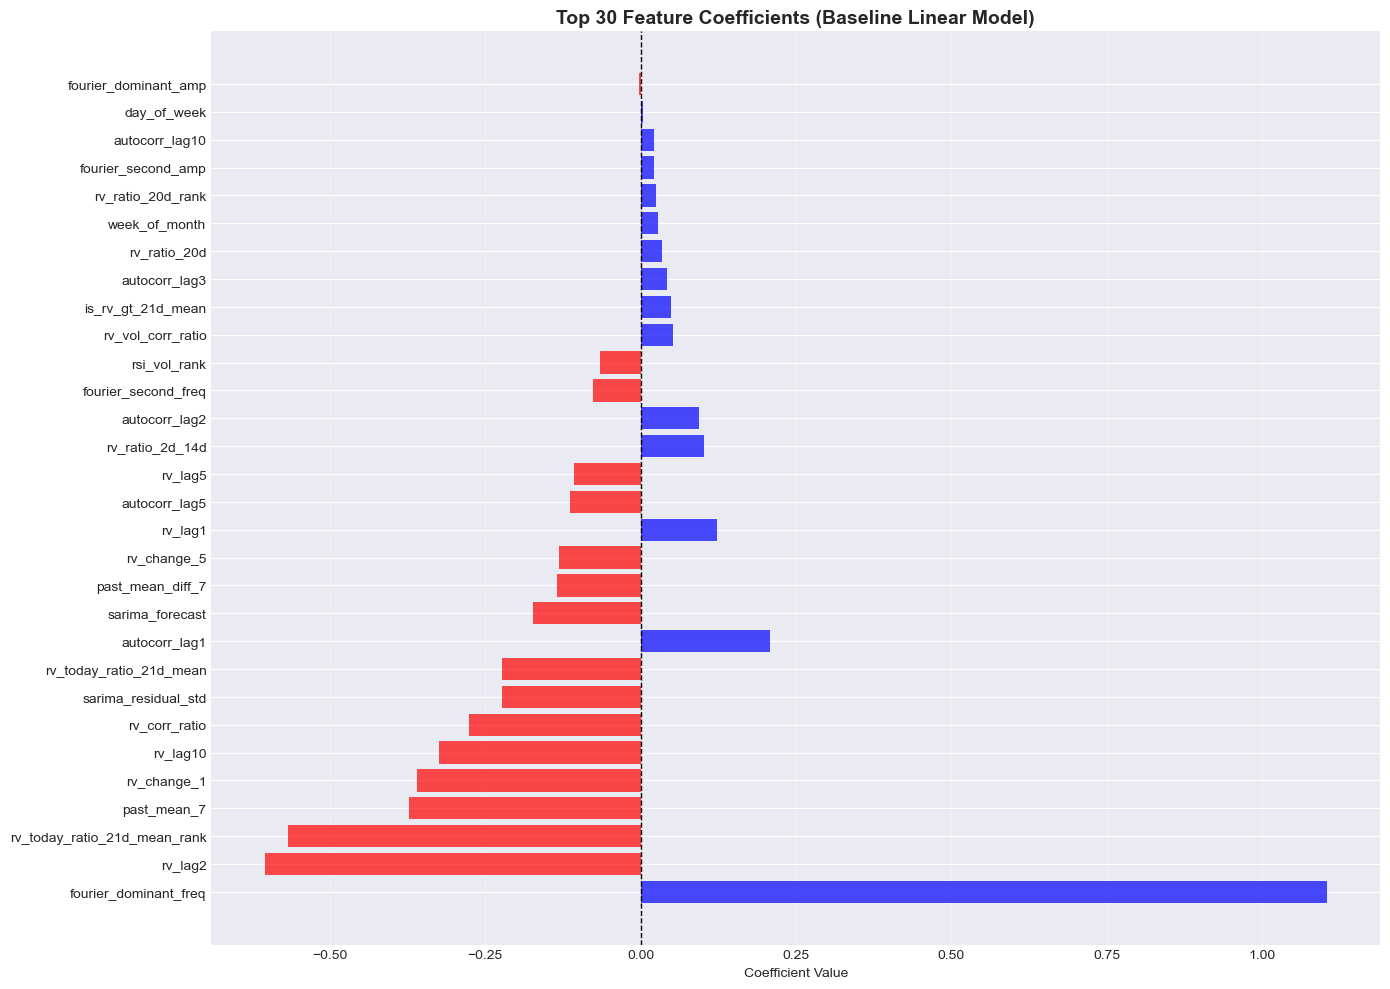


HAR-RV MODEL: Feature Importance

HAR-RV Model Intercept: 0.134039

Feature Coefficients:
   feature  coefficient  abs_coefficient
  rv_daily    -0.748661         0.748661
 rv_weekly     0.251057         0.251057
rv_monthly    -0.126048         0.126048


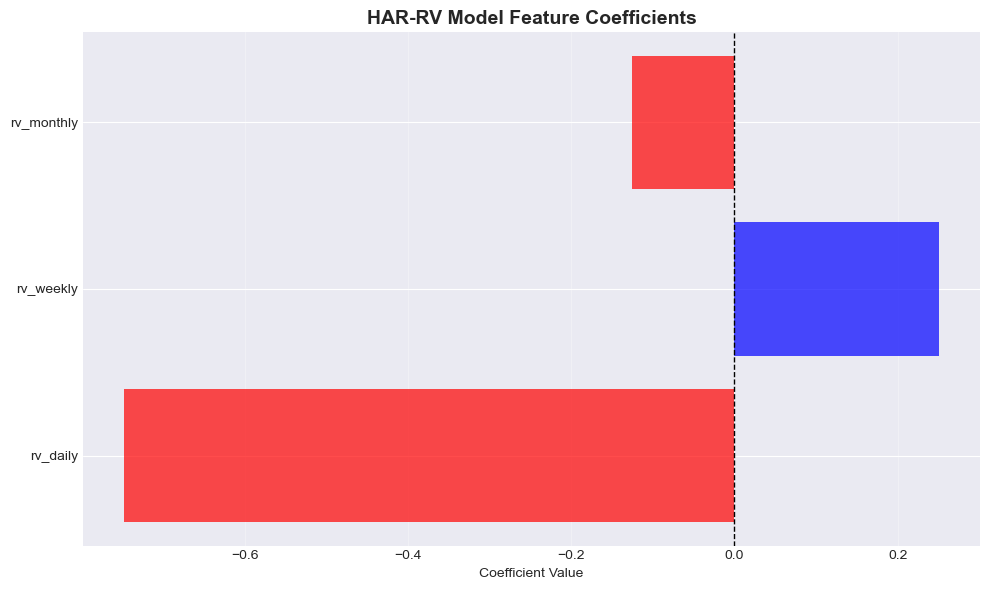


HAR-X MODEL: Feature Importance

HAR-X Model Intercept: 0.123663

Feature Coefficients:
   feature  coefficient  abs_coefficient
  ret_lag1     3.165012         3.165012
  ret_lag2     2.783722         2.783722
  ret_lag3     1.312135         1.312135
  rv_daily    -0.256643         0.256643
rv_monthly    -0.244202         0.244202
 rv_weekly    -0.088800         0.088800


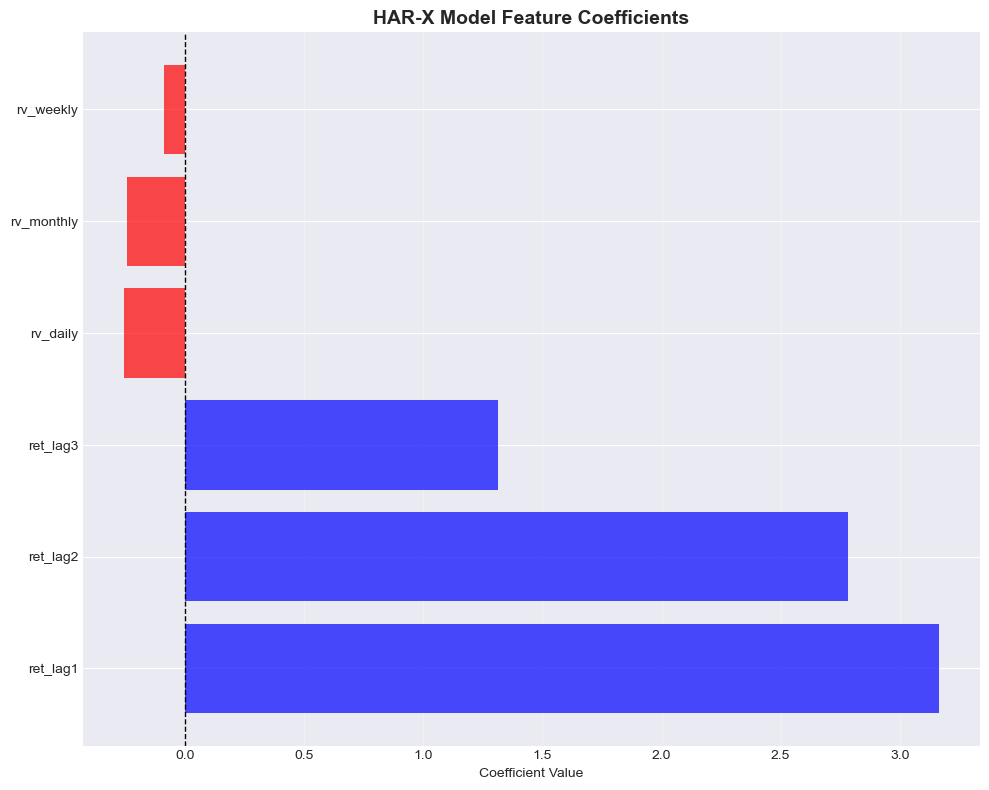


Feature Importance Analysis Complete!


In [ ]:
# ============================================================================
# MODEL SELECTOR & ENHANCED PLOTS
# ============================================================================
# Select which models to plot and analyze

# Available models
available_models = ['RandomForest', 'Baseline Linear', 'HAR-RV', 'HAR-X', 'Neural Network', 'Ensemble']

# Model selector - set to True to include in plots
model_selection = {
    'RandomForest': True,
    'Baseline Linear': True,
    'HAR-RV': True,
    'HAR-X': True,
    'Neural Network': True,
    'Ensemble': True
}

# Filter selected models
selected_models = [m for m in available_models if model_selection.get(m, False)]
print("=" * 70)
print("MODEL SELECTOR & ENHANCED ANALYSIS")
print("=" * 70)
print(f"\nSelected models for plotting: {', '.join(selected_models)}")
print(f"Total models selected: {len(selected_models)}")

if len(selected_models) == 0:
    print("\nWARNING: No models selected! Please set at least one model to True in model_selection.")
else:
    # Filter results for selected models
    selected_results_df = results_df[results_df['Model'].isin(selected_models)].copy()
    selected_models_results = {k: v for k, v in models_results.items() if k in selected_models}
    
    # ============================================================================
    # ENHANCED PLOTS WITH MODEL SELECTOR
    # ============================================================================
    print("\n" + "=" * 70)
    print("Generating Enhanced Comparison Plots (Selected Models Only)")
    print("=" * 70)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Define metrics to plot (matching column names in selected_results_df)
    metrics = ['RMSE_logdiff', 'MAE_logdiff', 'Directional_Acc', 'Correlation']
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        model_names = selected_results_df['Model'].values
        values = selected_results_df[metric].values
        bars = ax.bar(model_names, values, alpha=0.7, edgecolor='black')
        ax.set_title(f'{metric} Comparison (Selected Models)', fontsize=12, fontweight='bold')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('model_comparison_metrics_selected.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Time series plot: Actual vs Predictions (selected models only)
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(common_test_idx[:200] if len(common_test_idx) > 200 else common_test_idx, 
            y_test_aligned[:200] if len(y_test_aligned) > 200 else y_test_aligned,
            label='Actual rv_logdiff', linewidth=2, alpha=0.7, color='black')
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(selected_models)))
    for i, (model_name, pred) in enumerate(selected_models_results.items()):
        pred_values = pred[:200] if len(pred) > 200 else pred
        ax.plot(common_test_idx[:200] if len(common_test_idx) > 200 else common_test_idx,
                pred_values, label=f'{model_name} Forecast', alpha=0.6, linewidth=1.5, color=colors[i])
    
    ax.set_title(f'Actual vs Predicted rv_logdiff (Test Set - First 200 points, Selected Models)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('rv_logdiff')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_forecasts_comparison_selected.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # ============================================================================
    # RV QUANTILE ANALYSIS
    # ============================================================================
    print("\n" + "=" * 70)
    print("RV QUANTILE ANALYSIS: Model Performance by Volatility Regime")
    print("=" * 70)
    
    # Get actual RV values for quantile analysis
    # rv_logdiff = log(rv_fwd) - log(rv_today), so rv_fwd = exp(rv_logdiff + log(rv_today))
    eps = 1e-12
    test_rv_today = test_data['rv_today'].loc[common_test_idx].values if len(common_test_idx) > 0 else test_data['rv_today'].values[:len(y_test_aligned)]
    actual_future_rv = np.exp(y_test_aligned + np.log(test_rv_today + eps)) - eps
    
    quantiles = [0.33, 0.67]  # Low, Medium, High
    quantile_labels = ['Low Vol', 'Medium Vol', 'High Vol']
    
    # Compute quantile thresholds on TRAIN ONLY (to avoid lookahead)
    train_rv_today = train_data['rv_today'].values
    train_rv_logdiff = train_data[f'rv_logdiff_{FORECAST_TARGET}d'].values
    train_future_rv = np.exp(train_rv_logdiff + np.log(train_rv_today + eps)) - eps
    q33 = np.percentile(train_future_rv, 33)
    q67 = np.percentile(train_future_rv, 67)
    
    # Create quantile masks
    low_vol_mask = actual_future_rv <= q33
    medium_vol_mask = (actual_future_rv > q33) & (actual_future_rv <= q67)
    high_vol_mask = actual_future_rv > q67
    
    quantile_masks = [low_vol_mask, medium_vol_mask, high_vol_mask]
    
    print(f"\nRV Quantile Thresholds (computed on TRAIN set, applied to TEST):")
    print(f"  Low Vol (≤33rd percentile): ≤ {q33:.4f}")
    print(f"  Medium Vol (33rd-67th percentile): {q33:.4f} - {q67:.4f}")
    print(f"  High Vol (>67th percentile): > {q67:.4f}")
    print(f"\nSample sizes per quantile:")
    print(f"  Low Vol: {low_vol_mask.sum()} samples")
    print(f"  Medium Vol: {medium_vol_mask.sum()} samples")
    print(f"  High Vol: {high_vol_mask.sum()} samples")
    
    # Evaluate each model in each quantile
    quantile_results = []
    
    for model_name in selected_models:
        pred = selected_models_results[model_name]
        model_results = {'Model': model_name}
        
        for quantile_label, mask in zip(quantile_labels, quantile_masks):
            if mask.sum() > 0:
                y_quantile = y_test_aligned[mask]  # rv_logdiff
                pred_quantile = pred[mask]  # rv_logdiff
                
                # Calculate metrics for this quantile (on rv_logdiff)
                r2_quantile = r2_score(y_quantile, pred_quantile)
                rmse_quantile = np.sqrt(mean_squared_error(y_quantile, pred_quantile))
                
                # Directional accuracy: convert to rv_diff for sign comparison
                quantile_rv_today = test_rv_today[mask]
                true_rv_fwd = np.exp(y_quantile + np.log(quantile_rv_today + eps)) - eps
                pred_rv_fwd = np.exp(pred_quantile + np.log(quantile_rv_today + eps)) - eps
                true_rv_diff = true_rv_fwd - quantile_rv_today
                pred_rv_diff = pred_rv_fwd - quantile_rv_today
                
                # Directional accuracy on rv_diff sign
                true_sign = np.sign(true_rv_diff)
                pred_sign = np.sign(pred_rv_diff)
                # Exclude zeros
                sign_mask = (true_sign != 0) & (pred_sign != 0)
                if sign_mask.sum() > 0:
                    hit_rate_quantile = np.mean(true_sign[sign_mask] == pred_sign[sign_mask])
                else:
                    hit_rate_quantile = np.nan
                
                model_results[f'{quantile_label}_R2'] = r2_quantile
                model_results[f'{quantile_label}_RMSE'] = rmse_quantile
                model_results[f'{quantile_label}_HitRate'] = hit_rate_quantile
            else:
                model_results[f'{quantile_label}_R2'] = np.nan
                model_results[f'{quantile_label}_RMSE'] = np.nan
                model_results[f'{quantile_label}_HitRate'] = np.nan
        
        quantile_results.append(model_results)
    
    quantile_results_df = pd.DataFrame(quantile_results)
    
    # Print quantile analysis results
    print("\n" + "=" * 70)
    print("MODEL PERFORMANCE BY VOLATILITY REGIME")
    print("=" * 70)
    
    for model_name in selected_models:
        model_row = quantile_results_df[quantile_results_df['Model'] == model_name].iloc[0]
        print(f"\n{model_name}:")
        for quantile_label in quantile_labels:
            print(f"  {quantile_label}:")
            print(f"    R²: {model_row[f'{quantile_label}_R2']:.4f}")
            print(f"    RMSE: {model_row[f'{quantile_label}_RMSE']:.6f}")
            print(f"    Hit Rate: {model_row[f'{quantile_label}_HitRate']:.4f}")
    
    # Plot quantile analysis
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Define metrics to plot (matching column names in quantile_results_df)
    metrics_quantile = ['R2', 'RMSE', 'HitRate']
    
    for idx, metric in enumerate(metrics_quantile):
        ax = axes[idx // 2, idx % 2]
        
        x = np.arange(len(selected_models))
        width = 0.25
        
        for i, quantile_label in enumerate(quantile_labels):
            values = [quantile_results_df[quantile_results_df['Model'] == m][f'{quantile_label}_{metric}'].values[0] 
                     for m in selected_models]
            ax.bar(x + i*width, values, width, label=quantile_label, alpha=0.7)
        
        ax.set_xlabel('Model')
        ax.set_ylabel(metric)
        ax.set_title(f'{metric} by Volatility Regime', fontsize=12, fontweight='bold')
        ax.set_xticks(x + width)
        ax.set_xticklabels(selected_models, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('model_quantile_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # ============================================================================
    # FEATURE IMPORTANCE FOR ALL MODELS
    # ============================================================================
    
    # 1. RANDOMFOREST MODEL FEATURE IMPORTANCE
    print("\n" + "=" * 70)
    print("RANDOMFOREST MODEL: Feature Importance")
    print("=" * 70)
    
    rf_feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 30 Most Important Features:")
    print(rf_feature_importance.head(30).to_string(index=False))
    
    # Plot RandomForest feature importance
    fig, ax = plt.subplots(figsize=(14, 10))
    top_n = 30
    top_features_rf = rf_feature_importance.head(top_n)
    
    y_pos = np.arange(len(top_features_rf))
    ax.barh(y_pos, top_features_rf['importance'].values, color='steelblue', alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_features_rf['feature'].values)
    ax.set_xlabel('Feature Importance')
    ax.set_title(f'Top {top_n} Feature Importance (RandomForest Model)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('randomforest_feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 2. BASELINE LINEAR MODEL FEATURE IMPORTANCE
    print("\n" + "=" * 70)
    print("BASELINE LINEAR MODEL: Feature Importance")
    print("=" * 70)
    
    # Get coefficients from linear model
    linear_coefs = baseline_model.coef_
    linear_intercept = baseline_model.intercept_
    
    # Create feature importance dataframe
    linear_feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'coefficient': linear_coefs,
        'abs_coefficient': np.abs(linear_coefs)
    }).sort_values('abs_coefficient', ascending=False)
    
    print(f"\nLinear Model Intercept: {linear_intercept:.6f}")
    print(f"\nTop 30 Most Important Features (by absolute coefficient):")
    print(linear_feature_importance.head(30).to_string(index=False))
    
    # Plot feature importance
    fig, ax = plt.subplots(figsize=(14, 10))
    top_n = 30
    top_features = linear_feature_importance.head(top_n)
    
    y_pos = np.arange(len(top_features))
    colors_bar = ['red' if coef < 0 else 'blue' for coef in top_features['coefficient'].values]
    
    ax.barh(y_pos, top_features['coefficient'].values, color=colors_bar, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_features['feature'].values)
    ax.set_xlabel('Coefficient Value')
    ax.set_title(f'Top {top_n} Feature Coefficients (Baseline Linear Model)', fontsize=14, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('linear_model_feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 3. HAR-RV MODEL FEATURE IMPORTANCE
    print("\n" + "=" * 70)
    print("HAR-RV MODEL: Feature Importance")
    print("=" * 70)
    
    # Get HAR-RV model parameters (skip intercept which is first)
    har_params = har_model.params
    # Get actual feature names from HAR-RV model (exclude 'const' which is the intercept)
    har_feature_names = [name for name in har_params.index if name != 'const']
    
    har_feature_importance = pd.DataFrame({
        'feature': har_feature_names,
        'coefficient': har_params[har_feature_names].values,
        'abs_coefficient': np.abs(har_params[har_feature_names].values)
    }).sort_values('abs_coefficient', ascending=False)
    
    print(f"\nHAR-RV Model Intercept: {har_params[0]:.6f}")
    print(f"\nFeature Coefficients:")
    print(har_feature_importance.to_string(index=False))
    
    # Plot HAR-RV feature importance
    fig, ax = plt.subplots(figsize=(10, 6))
    y_pos = np.arange(len(har_feature_importance))
    colors_bar = ['red' if coef < 0 else 'blue' for coef in har_feature_importance['coefficient'].values]
    
    ax.barh(y_pos, har_feature_importance['coefficient'].values, color=colors_bar, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(har_feature_importance['feature'].values)
    ax.set_xlabel('Coefficient Value')
    ax.set_title('HAR-RV Model Feature Coefficients', fontsize=14, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('har_rv_feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 4. HAR-X MODEL FEATURE IMPORTANCE
    print("\n" + "=" * 70)
    print("HAR-X MODEL: Feature Importance")
    print("=" * 70)
    
    # Get HAR-X model parameters (skip intercept which is first)
    harx_params = harx_model.params
    # Get actual feature names from HAR-X model (exclude 'const' which is the intercept)
    harx_feature_names = [name for name in harx_params.index if name != 'const']
    
    harx_feature_importance = pd.DataFrame({
        'feature': harx_feature_names,
        'coefficient': harx_params[harx_feature_names].values,
        'abs_coefficient': np.abs(harx_params[harx_feature_names].values)
    }).sort_values('abs_coefficient', ascending=False)
    
    print(f"\nHAR-X Model Intercept: {harx_params[0]:.6f}")
    print(f"\nFeature Coefficients:")
    print(harx_feature_importance.to_string(index=False))
    
    # Plot HAR-X feature importance
    fig, ax = plt.subplots(figsize=(10, 8))
    y_pos = np.arange(len(harx_feature_importance))
    colors_bar = ['red' if coef < 0 else 'blue' for coef in harx_feature_importance['coefficient'].values]
    
    ax.barh(y_pos, harx_feature_importance['coefficient'].values, color=colors_bar, alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(harx_feature_importance['feature'].values)
    ax.set_xlabel('Coefficient Value')
    ax.set_title('HAR-X Model Feature Coefficients', fontsize=14, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('har_x_feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "=" * 70)
    print("Feature Importance Analysis Complete!")
    print("=" * 70)



RESIDUAL ANALYSIS: Validation and Test Sets

Selected model for distribution plots: RandomForest


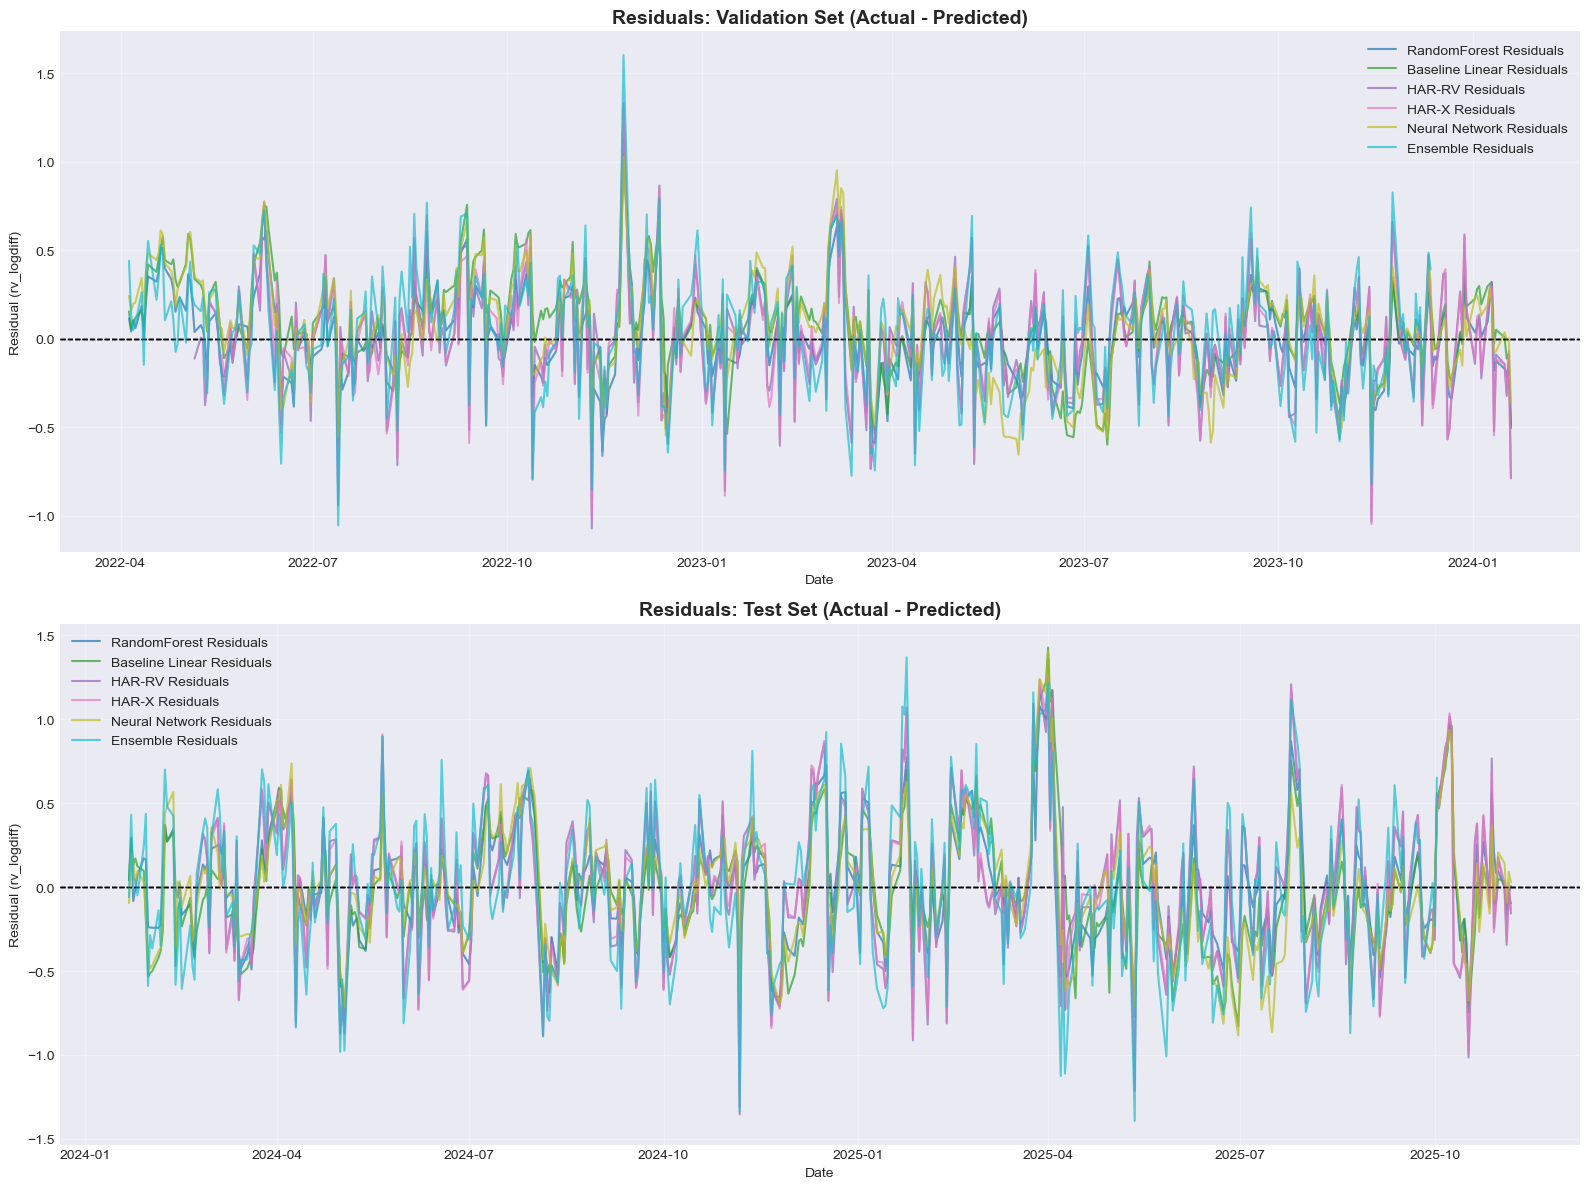


DISTRIBUTION PLOTS: RandomForest


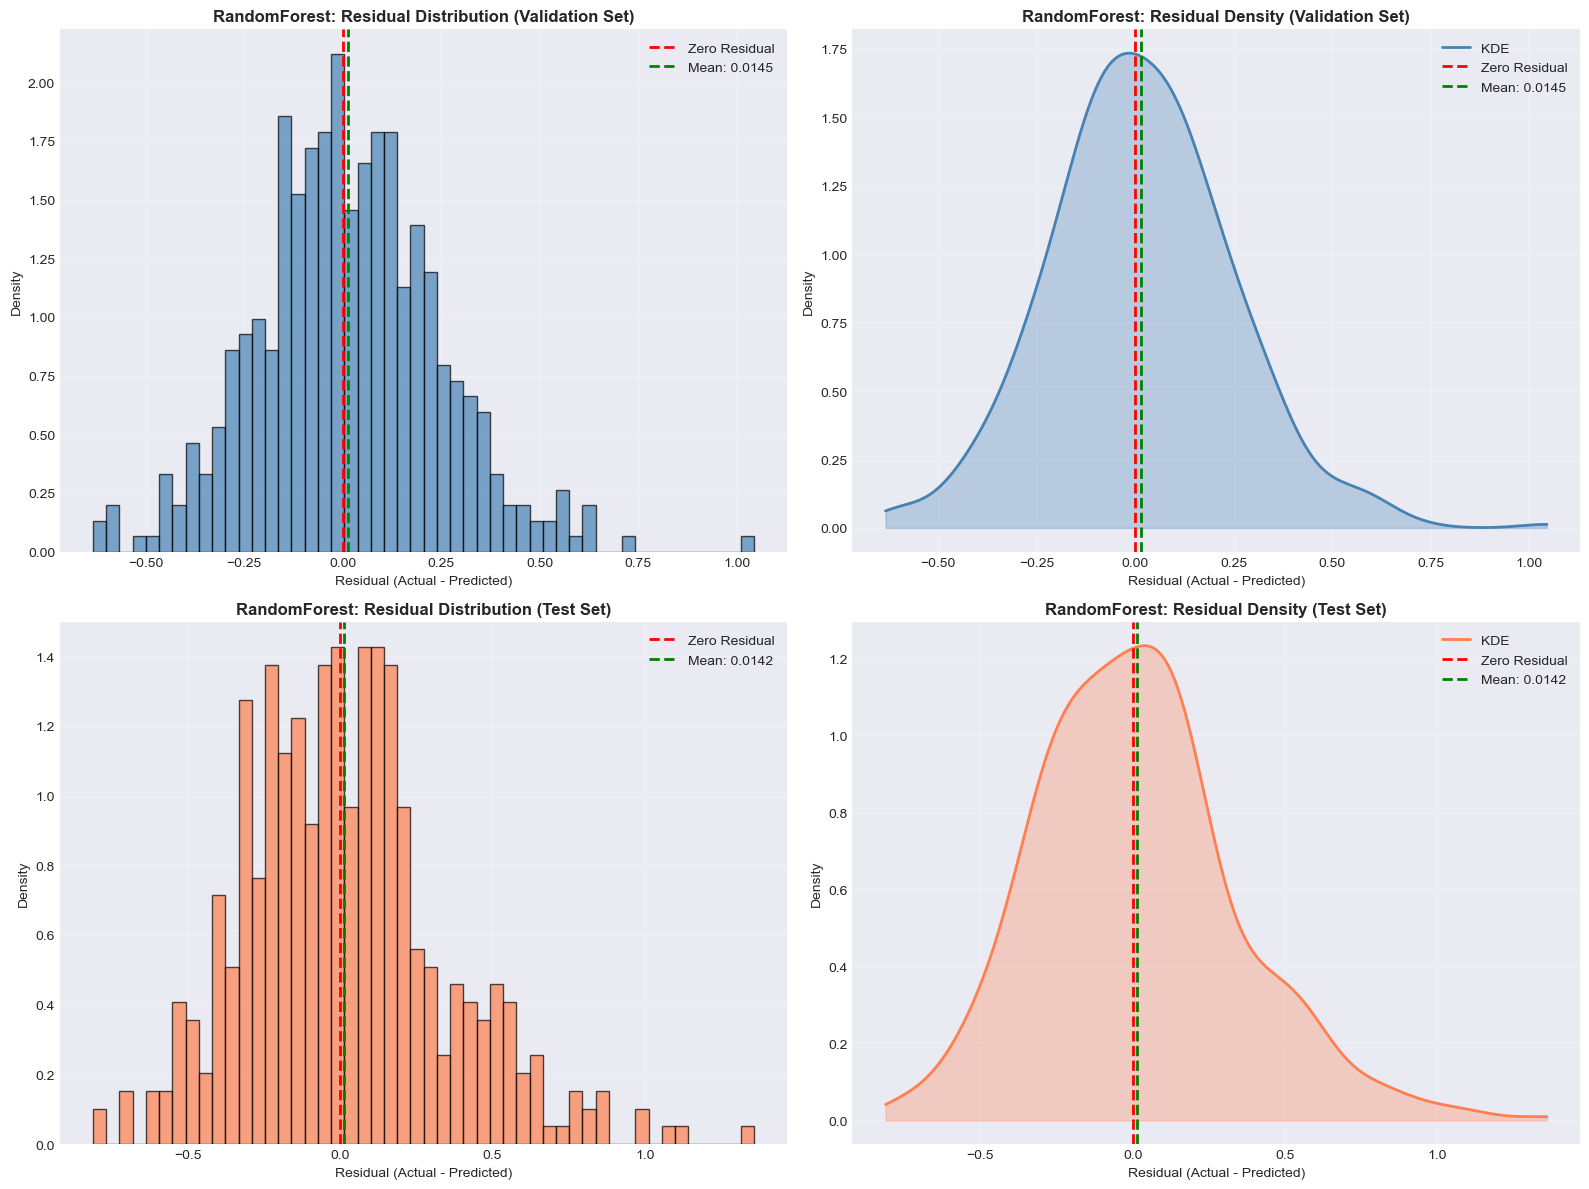


RandomForest - Residual Distribution Statistics:
  Validation Set:
    Mean: 0.014522
    Median: 0.003409
    Std: 0.232315
    Skewness: 0.2507
    Kurtosis: 0.7992
    Min: -0.633312
    Max: 1.044752
    Q1 (25th percentile): -0.135673
    Q3 (75th percentile): 0.157192
    IQR: 0.292865

  Test Set:
    Mean: 0.014227
    Median: -0.009317
    Std: 0.329958
    Skewness: 0.5671
    Kurtosis: 0.7656
    Min: -0.811154
    Max: 1.360182
    Q1 (25th percentile): -0.217531
    Q3 (75th percentile): 0.184768
    IQR: 0.402299

RESIDUAL STATISTICS

RandomForest:
  Validation Set:
    Mean Residual: 0.014522
    Std Residual: 0.232315
    Min Residual: -0.633312
    Max Residual: 1.044752
    MAE: 0.180904
  Test Set:
    Mean Residual: 0.014227
    Std Residual: 0.329958
    Min Residual: -0.811154
    Max Residual: 1.360182
    MAE: 0.255781

Baseline Linear:
  Validation Set:
    Mean Residual: 0.082636
    Std Residual: 0.254916
    Min Residual: -0.598387
    Max Residual: 1.13299

In [78]:
# ============================================================================
# RESIDUAL PLOTS FOR SELECTED MODELS
# ============================================================================
print("\n" + "=" * 70)
print("RESIDUAL ANALYSIS: Validation and Test Sets")
print("=" * 70)

# Select a single model for detailed distribution plots
# Options: 'RandomForest', 'Baseline Linear', 'HAR-RV', 'HAR-X', 'Neural Network', 'Ensemble'
# Must be one of the selected_models
selected_model_for_distribution = 'RandomForest'  # Change this to plot a different model

# Validate selection
if selected_model_for_distribution not in selected_models:
    print(f"\nWARNING: {selected_model_for_distribution} is not in selected_models.")
    print(f"Available models: {selected_models}")
    if len(selected_models) > 0:
        selected_model_for_distribution = selected_models[0]
        print(f"Using first selected model instead: {selected_model_for_distribution}")
    else:
        print("ERROR: No models selected. Skipping distribution plots.")
        selected_model_for_distribution = None
else:
    print(f"\nSelected model for distribution plots: {selected_model_for_distribution}")

# Get predictions for selected models on validation and test sets
selected_models_val_pred = {}
selected_models_test_pred = {}

for model_name in selected_models:
    if model_name == 'RandomForest':
        selected_models_val_pred[model_name] = y_val_pred
        selected_models_test_pred[model_name] = y_test_pred
    elif model_name == 'Baseline Linear':
        selected_models_val_pred[model_name] = baseline_pred_val
        selected_models_test_pred[model_name] = baseline_pred_test
    elif model_name == 'Neural Network':
        selected_models_val_pred[model_name] = nn_pred_val
        selected_models_test_pred[model_name] = nn_pred_test
    elif model_name == 'HAR-RV':
        # Align HAR predictions to validation/test indices
        val_idx = val_data.index.intersection(har_y_val.index)
        test_idx = test_data.index.intersection(har_y_test.index)
        if len(val_idx) > 0:
            selected_models_val_pred[model_name] = pd.Series(har_pred_val, index=har_y_val.index).loc[val_idx].values
        else:
            selected_models_val_pred[model_name] = har_pred_val.values
        if len(test_idx) > 0:
            selected_models_test_pred[model_name] = pd.Series(har_pred_test, index=har_y_test.index).loc[test_idx].values
        else:
            selected_models_test_pred[model_name] = har_pred_test.values
    elif model_name == 'HAR-X':
        # Align HAR-X predictions to validation/test indices
        val_idx = val_data.index.intersection(harx_y_val.index)
        test_idx = test_data.index.intersection(harx_y_test.index)
        if len(val_idx) > 0:
            selected_models_val_pred[model_name] = pd.Series(harx_pred_val, index=harx_y_val.index).loc[val_idx].values
        else:
            selected_models_val_pred[model_name] = harx_pred_val.values
        if len(test_idx) > 0:
            selected_models_test_pred[model_name] = pd.Series(harx_pred_test, index=harx_y_test.index).loc[test_idx].values
        else:
            selected_models_test_pred[model_name] = harx_pred_test.values
    elif model_name == 'Ensemble':
        # Ensemble: average of all available models
        ensemble_val_preds = []
        ensemble_test_preds = []
        val_common_idx = val_data.index
        test_common_idx = test_data.index
        
        if 'RandomForest' in selected_models:
            ensemble_val_preds.append(pd.Series(y_val_pred, index=val_data.index))
            ensemble_test_preds.append(pd.Series(y_test_pred, index=test_data.index))
        if 'Baseline Linear' in selected_models:
            ensemble_val_preds.append(pd.Series(baseline_pred_val, index=val_data.index))
            ensemble_test_preds.append(pd.Series(baseline_pred_test, index=test_data.index))
        if 'Neural Network' in selected_models:
            ensemble_val_preds.append(pd.Series(nn_pred_val, index=val_data.index))
            ensemble_test_preds.append(pd.Series(nn_pred_test, index=test_data.index))
        if 'HAR-RV' in selected_models:
            val_idx = val_data.index.intersection(har_y_val.index)
            test_idx = test_data.index.intersection(har_y_test.index)
            if len(val_idx) > 0:
                ensemble_val_preds.append(pd.Series(har_pred_val, index=har_y_val.index).reindex(val_data.index))
            if len(test_idx) > 0:
                ensemble_test_preds.append(pd.Series(har_pred_test, index=har_y_test.index).reindex(test_data.index))
        if 'HAR-X' in selected_models:
            val_idx = val_data.index.intersection(harx_y_val.index)
            test_idx = test_data.index.intersection(harx_y_test.index)
            if len(val_idx) > 0:
                ensemble_val_preds.append(pd.Series(harx_pred_val, index=harx_y_val.index).reindex(val_data.index))
            if len(test_idx) > 0:
                ensemble_test_preds.append(pd.Series(harx_pred_test, index=harx_y_test.index).reindex(test_data.index))
        
        # Compute ensemble as average (only where all models have predictions)
        if len(ensemble_val_preds) > 0:
            ensemble_val_df = pd.concat(ensemble_val_preds, axis=1).dropna()
            selected_models_val_pred[model_name] = ensemble_val_df.mean(axis=1).values
            val_common_idx = ensemble_val_df.index
        if len(ensemble_test_preds) > 0:
            ensemble_test_df = pd.concat(ensemble_test_preds, axis=1).dropna()
            selected_models_test_pred[model_name] = ensemble_test_df.mean(axis=1).values
            test_common_idx = ensemble_test_df.index

# Compute residuals and plot
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Validation set residuals
ax_val = axes[0]
val_colors = plt.cm.tab10(np.linspace(0, 1, len(selected_models)))

for i, model_name in enumerate(selected_models):
    if model_name in selected_models_val_pred:
        # Get aligned actual values
        if model_name in ['HAR-RV', 'HAR-X']:
            if model_name == 'HAR-RV':
                val_idx = val_data.index.intersection(har_y_val.index)
                y_val_aligned = har_y_val.loc[val_idx].values if len(val_idx) > 0 else har_y_val.values
                val_dates = har_y_val.index if len(val_idx) == 0 else val_idx
            else:  # HAR-X
                val_idx = val_data.index.intersection(harx_y_val.index)
                y_val_aligned = harx_y_val.loc[val_idx].values if len(val_idx) > 0 else harx_y_val.values
                val_dates = harx_y_val.index if len(val_idx) == 0 else val_idx
        else:
            y_val_aligned = y_val
            val_dates = val_data.index
        
        pred_val = selected_models_val_pred[model_name]
        # Ensure same length
        min_len = min(len(y_val_aligned), len(pred_val))
        residuals_val = y_val_aligned[:min_len] - pred_val[:min_len]
        
        ax_val.plot(val_dates[:min_len], residuals_val, 
                   label=f'{model_name} Residuals', alpha=0.7, linewidth=1.5, color=val_colors[i])
        ax_val.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax_val.set_title('Residuals: Validation Set (Actual - Predicted)', fontsize=14, fontweight='bold')
ax_val.set_xlabel('Date')
ax_val.set_ylabel('Residual (rv_logdiff)')
ax_val.legend(loc='best')
ax_val.grid(True, alpha=0.3)

# Test set residuals
ax_test = axes[1]
test_colors = plt.cm.tab10(np.linspace(0, 1, len(selected_models)))

for i, model_name in enumerate(selected_models):
    if model_name in selected_models_test_pred:
        # Get aligned actual values
        if model_name in ['HAR-RV', 'HAR-X']:
            if model_name == 'HAR-RV':
                test_idx = test_data.index.intersection(har_y_test.index)
                y_test_aligned_model = har_y_test.loc[test_idx].values if len(test_idx) > 0 else har_y_test.values
                test_dates = har_y_test.index if len(test_idx) == 0 else test_idx
            else:  # HAR-X
                test_idx = test_data.index.intersection(harx_y_test.index)
                y_test_aligned_model = harx_y_test.loc[test_idx].values if len(test_idx) > 0 else harx_y_test.values
                test_dates = harx_y_test.index if len(test_idx) == 0 else test_idx
        else:
            y_test_aligned_model = y_test
            test_dates = test_data.index
        
        pred_test = selected_models_test_pred[model_name]
        # Ensure same length
        min_len = min(len(y_test_aligned_model), len(pred_test))
        residuals_test = y_test_aligned_model[:min_len] - pred_test[:min_len]
        
        ax_test.plot(test_dates[:min_len], residuals_test, 
                    label=f'{model_name} Residuals', alpha=0.7, linewidth=1.5, color=test_colors[i])
        ax_test.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax_test.set_title('Residuals: Test Set (Actual - Predicted)', fontsize=14, fontweight='bold')
ax_test.set_xlabel('Date')
ax_test.set_ylabel('Residual (rv_logdiff)')
ax_test.legend(loc='best')
ax_test.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_residuals_val_test.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# DISTRIBUTION PLOTS FOR SINGLE SELECTED MODEL
# ============================================================================
if selected_model_for_distribution and selected_model_for_distribution in selected_models_val_pred:
    print("\n" + "=" * 70)
    print(f"DISTRIBUTION PLOTS: {selected_model_for_distribution}")
    print("=" * 70)
    
    # Get residuals for the selected model
    model_name = selected_model_for_distribution
    
    # Validation residuals
    if model_name in ['HAR-RV', 'HAR-X']:
        if model_name == 'HAR-RV':
            val_idx = val_data.index.intersection(har_y_val.index)
            y_val_aligned = har_y_val.loc[val_idx].values if len(val_idx) > 0 else har_y_val.values
        else:  # HAR-X
            val_idx = val_data.index.intersection(harx_y_val.index)
            y_val_aligned = harx_y_val.loc[val_idx].values if len(val_idx) > 0 else harx_y_val.values
    else:
        y_val_aligned = y_val
    
    pred_val = selected_models_val_pred[model_name]
    min_len_val = min(len(y_val_aligned), len(pred_val))
    residuals_val = y_val_aligned[:min_len_val] - pred_val[:min_len_val]
    
    # Test residuals
    if model_name in ['HAR-RV', 'HAR-X']:
        if model_name == 'HAR-RV':
            test_idx = test_data.index.intersection(har_y_test.index)
            y_test_aligned_model = har_y_test.loc[test_idx].values if len(test_idx) > 0 else har_y_test.values
        else:  # HAR-X
            test_idx = test_data.index.intersection(harx_y_test.index)
            y_test_aligned_model = harx_y_test.loc[test_idx].values if len(test_idx) > 0 else harx_y_test.values
    else:
        y_test_aligned_model = y_test
    
    pred_test = selected_models_test_pred[model_name]
    min_len_test = min(len(y_test_aligned_model), len(pred_test))
    residuals_test = y_test_aligned_model[:min_len_test] - pred_test[:min_len_test]
    
    # Plot distributions
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Validation set: Histogram
    ax_val_hist = axes[0, 0]
    ax_val_hist.hist(residuals_val, bins=50, alpha=0.7, edgecolor='black', color='steelblue', density=True)
    ax_val_hist.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
    ax_val_hist.axvline(x=np.mean(residuals_val), color='green', linestyle='--', linewidth=2, 
                       label=f'Mean: {np.mean(residuals_val):.4f}')
    ax_val_hist.set_title(f'{model_name}: Residual Distribution (Validation Set)', fontsize=12, fontweight='bold')
    ax_val_hist.set_xlabel('Residual (Actual - Predicted)')
    ax_val_hist.set_ylabel('Density')
    ax_val_hist.legend()
    ax_val_hist.grid(True, alpha=0.3)
    
    # Validation set: Density plot (KDE)
    ax_val_kde = axes[0, 1]
    from scipy.stats import gaussian_kde
    if len(residuals_val) > 1:
        kde_val = gaussian_kde(residuals_val)
        x_val = np.linspace(residuals_val.min(), residuals_val.max(), 200)
        ax_val_kde.plot(x_val, kde_val(x_val), linewidth=2, color='steelblue', label='KDE')
        ax_val_kde.fill_between(x_val, kde_val(x_val), alpha=0.3, color='steelblue')
    ax_val_kde.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
    ax_val_kde.axvline(x=np.mean(residuals_val), color='green', linestyle='--', linewidth=2,
                       label=f'Mean: {np.mean(residuals_val):.4f}')
    ax_val_kde.set_title(f'{model_name}: Residual Density (Validation Set)', fontsize=12, fontweight='bold')
    ax_val_kde.set_xlabel('Residual (Actual - Predicted)')
    ax_val_kde.set_ylabel('Density')
    ax_val_kde.legend()
    ax_val_kde.grid(True, alpha=0.3)
    
    # Test set: Histogram
    ax_test_hist = axes[1, 0]
    ax_test_hist.hist(residuals_test, bins=50, alpha=0.7, edgecolor='black', color='coral', density=True)
    ax_test_hist.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
    ax_test_hist.axvline(x=np.mean(residuals_test), color='green', linestyle='--', linewidth=2,
                        label=f'Mean: {np.mean(residuals_test):.4f}')
    ax_test_hist.set_title(f'{model_name}: Residual Distribution (Test Set)', fontsize=12, fontweight='bold')
    ax_test_hist.set_xlabel('Residual (Actual - Predicted)')
    ax_test_hist.set_ylabel('Density')
    ax_test_hist.legend()
    ax_test_hist.grid(True, alpha=0.3)
    
    # Test set: Density plot (KDE)
    ax_test_kde = axes[1, 1]
    if len(residuals_test) > 1:
        kde_test = gaussian_kde(residuals_test)
        x_test = np.linspace(residuals_test.min(), residuals_test.max(), 200)
        ax_test_kde.plot(x_test, kde_test(x_test), linewidth=2, color='coral', label='KDE')
        ax_test_kde.fill_between(x_test, kde_test(x_test), alpha=0.3, color='coral')
    ax_test_kde.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
    ax_test_kde.axvline(x=np.mean(residuals_test), color='green', linestyle='--', linewidth=2,
                       label=f'Mean: {np.mean(residuals_test):.4f}')
    ax_test_kde.set_title(f'{model_name}: Residual Density (Test Set)', fontsize=12, fontweight='bold')
    ax_test_kde.set_xlabel('Residual (Actual - Predicted)')
    ax_test_kde.set_ylabel('Density')
    ax_test_kde.legend()
    ax_test_kde.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'residual_distribution_{model_name.replace(" ", "_")}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print distribution statistics
    print(f"\n{model_name} - Residual Distribution Statistics:")
    print(f"  Validation Set:")
    print(f"    Mean: {np.mean(residuals_val):.6f}")
    print(f"    Median: {np.median(residuals_val):.6f}")
    print(f"    Std: {np.std(residuals_val):.6f}")
    print(f"    Skewness: {skew(residuals_val):.4f}")
    print(f"    Kurtosis: {kurtosis(residuals_val):.4f}")
    print(f"    Min: {np.min(residuals_val):.6f}")
    print(f"    Max: {np.max(residuals_val):.6f}")
    print(f"    Q1 (25th percentile): {np.percentile(residuals_val, 25):.6f}")
    print(f"    Q3 (75th percentile): {np.percentile(residuals_val, 75):.6f}")
    print(f"    IQR: {np.percentile(residuals_val, 75) - np.percentile(residuals_val, 25):.6f}")
    
    print(f"\n  Test Set:")
    print(f"    Mean: {np.mean(residuals_test):.6f}")
    print(f"    Median: {np.median(residuals_test):.6f}")
    print(f"    Std: {np.std(residuals_test):.6f}")
    print(f"    Skewness: {skew(residuals_test):.4f}")
    print(f"    Kurtosis: {kurtosis(residuals_test):.4f}")
    print(f"    Min: {np.min(residuals_test):.6f}")
    print(f"    Max: {np.max(residuals_test):.6f}")
    print(f"    Q1 (25th percentile): {np.percentile(residuals_test, 25):.6f}")
    print(f"    Q3 (75th percentile): {np.percentile(residuals_test, 75):.6f}")
    print(f"    IQR: {np.percentile(residuals_test, 75) - np.percentile(residuals_test, 25):.6f}")

# Print residual statistics
print("\n" + "=" * 70)
print("RESIDUAL STATISTICS")
print("=" * 70)

for model_name in selected_models:
    if model_name in selected_models_val_pred and model_name in selected_models_test_pred:
        print(f"\n{model_name}:")
        
        # Validation residuals
        if model_name in ['HAR-RV', 'HAR-X']:
            if model_name == 'HAR-RV':
                val_idx = val_data.index.intersection(har_y_val.index)
                y_val_aligned = har_y_val.loc[val_idx].values if len(val_idx) > 0 else har_y_val.values
            else:
                val_idx = val_data.index.intersection(harx_y_val.index)
                y_val_aligned = harx_y_val.loc[val_idx].values if len(val_idx) > 0 else harx_y_val.values
        else:
            y_val_aligned = y_val
        
        pred_val = selected_models_val_pred[model_name]
        min_len_val = min(len(y_val_aligned), len(pred_val))
        residuals_val = y_val_aligned[:min_len_val] - pred_val[:min_len_val]
        
        # Test residuals
        if model_name in ['HAR-RV', 'HAR-X']:
            if model_name == 'HAR-RV':
                test_idx = test_data.index.intersection(har_y_test.index)
                y_test_aligned_model = har_y_test.loc[test_idx].values if len(test_idx) > 0 else har_y_test.values
            else:
                test_idx = test_data.index.intersection(harx_y_test.index)
                y_test_aligned_model = harx_y_test.loc[test_idx].values if len(test_idx) > 0 else harx_y_test.values
        else:
            y_test_aligned_model = y_test
        
        pred_test = selected_models_test_pred[model_name]
        min_len_test = min(len(y_test_aligned_model), len(pred_test))
        residuals_test = y_test_aligned_model[:min_len_test] - pred_test[:min_len_test]
        
        print(f"  Validation Set:")
        print(f"    Mean Residual: {np.mean(residuals_val):.6f}")
        print(f"    Std Residual: {np.std(residuals_val):.6f}")
        print(f"    Min Residual: {np.min(residuals_val):.6f}")
        print(f"    Max Residual: {np.max(residuals_val):.6f}")
        print(f"    MAE: {np.mean(np.abs(residuals_val)):.6f}")
        
        print(f"  Test Set:")
        print(f"    Mean Residual: {np.mean(residuals_test):.6f}")
        print(f"    Std Residual: {np.std(residuals_test):.6f}")
        print(f"    Min Residual: {np.min(residuals_test):.6f}")
        print(f"    Max Residual: {np.max(residuals_test):.6f}")
        print(f"    MAE: {np.mean(np.abs(residuals_test)):.6f}")

print("\n" + "=" * 70)

In [ ]:
# ============================================================================
# REGIME-BASED CONDITIONING ANALYSIS (OBSERVABLE AT TIME T)
# ============================================================================
# "Trust NN high-vol predictions" - Conditioning on CURRENT regime (observable)
# This analysis conditions on CURRENT regime at time t (not future RV)
# All thresholds computed on TRAIN ONLY to avoid leakage

print("=" * 70)
print("REGIME-BASED CONDITIONING ANALYSIS (OBSERVABLE AT TIME T)")
print("=" * 70)
print("\nThis analysis conditions model performance on CURRENT volatility regime")
print("(observable at time t), not future realized RV.\n")

# ============================================================================
# Step 1: Build current regime labels using only past data
# ============================================================================
print("Step 1: Building current regime labels using rolling 5-day RV mean...")

# Compute RV5_t (rolling 5-day mean of daily RV) - uses only past data
# This is observable at time t
rv5_t = df_features['rv_today'].rolling(window=5, min_periods=5).mean()

# ============================================================================
# Step 2: Compute 33/67% thresholds on TRAIN ONLY and freeze them
# ============================================================================
print("Step 2: Computing regime thresholds on TRAIN ONLY...")

# Get RV5 values for training set only
train_rv5 = rv5_t.loc[train_data.index].dropna()

# Compute percentiles on TRAIN ONLY
threshold_33 = train_rv5.quantile(0.33)
threshold_67 = train_rv5.quantile(0.67)

print(f"  Low-Med threshold (33rd percentile): {threshold_33:.6f}")
print(f"  Med-High threshold (67th percentile): {threshold_67:.6f}")

# Apply thresholds to ALL data (train, val, test) to get current regime labels
# Regime_t ∈ {low, med, high}
regime_labels = pd.Series(index=df_features.index, dtype=str)
regime_labels[rv5_t <= threshold_33] = 'low'
regime_labels[(rv5_t > threshold_33) & (rv5_t <= threshold_67)] = 'med'
regime_labels[rv5_t > threshold_67] = 'high'

# ============================================================================
# Step 3: Define FutureHigh_t and PredHigh_t
# ============================================================================
print("\nStep 3: Defining FutureHigh and PredHigh indicators...")

# Regime is based on current RV level (rv_today), not future change
# Target is rv_logdiff (future change), not RV level
# Predictions are rv_logdiff (future change)
current_rv = df_features['rv_today']

# Compute threshold for current RV regimes on TRAIN ONLY
train_current_rv = current_rv.loc[train_data.index].dropna()
current_rv_threshold_67 = train_current_rv.quantile(0.67)
current_rv_threshold_33 = train_current_rv.quantile(0.33)

print(f"  Current RV thresholds (computed on train set):")
print(f"    Low-Med threshold (33rd percentile): {current_rv_threshold_33:.6f}")
print(f"    Med-High threshold (67th percentile): {current_rv_threshold_67:.6f}")

# Define regimes based on current RV level
regime_labels = pd.Series(index=df_features.index, dtype=str)
regime_labels[current_rv <= current_rv_threshold_33] = 'low'
regime_labels[(current_rv > current_rv_threshold_33) & (current_rv <= current_rv_threshold_67)] = 'med'
regime_labels[current_rv > current_rv_threshold_67] = 'high'

# FutureHigh: whether future rv_logdiff is positive (increase)
future_high = (df_features[f'rv_logdiff_{FORECAST_TARGET}d'] > 0).astype(int)

# For predictions, we'll compute PredHigh_t for each model
# PredHigh_t = 1{ y_pred > train 67% threshold of predictions }
# OR top-33% of predictions (we'll use threshold method for consistency)

# ============================================================================
# Step 4: Compute metrics for each model and each current regime
# ============================================================================
print("\nStep 4: Computing metrics for each model and regime...")

# Get test set indices with valid regime labels
test_idx_with_regime = test_data.index.intersection(regime_labels.dropna().index)
test_idx_with_regime = test_idx_with_regime.intersection(future_high.dropna().index)

# Get actual future RV for test set
y_test_actual = df_features[f'rv_logdiff_{FORECAST_TARGET}d'].loc[test_idx_with_regime]

# Get regime labels for test set
test_regimes = regime_labels.loc[test_idx_with_regime]
test_future_high = future_high.loc[test_idx_with_regime]

# Initialize results storage
regime_results = {}

# Process each model
for model_name, pred_values in models_results.items():
    if model_name == 'Ensemble':
        continue  # Skip ensemble for now, or handle separately
    
    print(f"\n  Processing {model_name}...")
    
    # Get predictions aligned to test set
    # predictions are already aligned to common_test_idx, need to align to test_idx_with_regime
    if model_name in ['RandomForest', 'Baseline Linear', 'Neural Network']:
        # These use common_test_idx
        pred_series = pd.Series(pred_values, index=common_test_idx)
    elif model_name == 'HAR-RV':
        pred_series = pd.Series(har_pred_test, index=har_y_test.index)
    elif model_name == 'HAR-X':
        pred_series = pd.Series(harx_pred_test, index=harx_y_test.index)
    else:
        continue
    
    # Find intersection of test_idx_with_regime and model's prediction index
    model_test_idx = pred_series.index.intersection(test_idx_with_regime)
    
    if len(model_test_idx) == 0:
        print(f"    Warning: No overlapping indices for {model_name}, skipping...")
        continue
    
    # Align predictions to intersection
    # Predictions are rv_logdiff (models predict rv_logdiff_{FORECAST_TARGET}d directly)
    pred_aligned = pred_series.loc[model_test_idx].values
    
    # Also align actual values and regime labels to the same intersection
    y_actual_model = y_test_actual.loc[model_test_idx].values
    test_regimes_model = test_regimes.loc[model_test_idx]
    test_future_high_model = test_future_high.loc[model_test_idx].values
    
    # Compute threshold for "high" predictions on TRAIN ONLY
    # Get train predictions for this model (these are rv_logdiff predictions)
    if model_name == 'RandomForest':
        train_pred_diff = model.predict(X_train)
        train_rv_today = train_data['rv_today'].values
    elif model_name == 'Baseline Linear':
        train_pred_diff = baseline_model.predict(X_train)
        train_rv_today = train_data['rv_today'].values
    elif model_name == 'Neural Network':
        train_pred_diff = nn_pred_train
        train_rv_today = train_data['rv_today'].values
    elif model_name == 'HAR-RV':
        # HAR models use different indices, need to align
        train_pred_diff = har_pred_train
        # Get RV today for HAR train indices
        har_train_idx = har_y_train.index
        train_rv_today = df_features['rv_today'].loc[har_train_idx].values
    elif model_name == 'HAR-X':
        # HAR-X models use different indices, need to align
        train_pred_diff = harx_pred_train
        # Get RV today for HAR-X train indices
        harx_train_idx = harx_y_train.index
        train_rv_today = df_features['rv_today'].loc[harx_train_idx].values
    else:
        continue
    
    # Train predictions are rv_logdiff (models predict rv_logdiff_{FORECAST_TARGET}d directly)
    # Ensure predictions are numpy arrays and have the same length
    train_pred_diff = np.array(train_pred_diff).flatten()
    train_rv_today = np.array(train_rv_today).flatten()
    
    # Handle length mismatch by taking minimum length
    min_len = min(len(train_pred_diff), len(train_rv_today))
    # Predictions are rv_logdiff (models predict rv_logdiff_{FORECAST_TARGET}d directly)
    # Convert to RV level for threshold computation: rv_fwd = exp(rv_logdiff + log(rv_today))
    train_pred = train_pred_diff[:min_len]  # train_pred_diff is actually rv_logdiff prediction
    
    # Compute threshold on train predictions (67th percentile)
    train_pred_threshold_67 = np.percentile(train_pred, 67)
    
    # PredHigh_t = 1{ y_pred > train 67% threshold }
    pred_high = (pred_aligned > train_pred_threshold_67).astype(int)
    
    # Compute metrics for each regime
    model_regime_results = []
    
    for regime in ['low', 'med', 'high']:
        regime_mask = (test_regimes_model == regime)
        n_regime = regime_mask.sum()
        
        if n_regime == 0:
            continue
        
        # Get data for this regime
        regime_pred = pred_aligned[regime_mask]
        regime_actual = y_actual_model[regime_mask]
        regime_future_high = test_future_high_model[regime_mask]
        regime_pred_high = pred_high[regime_mask]
        
        # Compute metrics
        # Precision_high(r) = P(FutureHigh=1 | PredHigh=1, Regime=r)
        pred_high_count = regime_pred_high.sum()
        if pred_high_count > 0:
            true_positives = ((regime_pred_high == 1) & (regime_future_high == 1)).sum()
            precision_high = true_positives / pred_high_count
        else:
            precision_high = np.nan
        
        # Recall_high(r) = P(PredHigh=1 | FutureHigh=1, Regime=r)
        future_high_count = regime_future_high.sum()
        if future_high_count > 0:
            true_positives = ((regime_pred_high == 1) & (regime_future_high == 1)).sum()
            recall_high = true_positives / future_high_count
        else:
            recall_high = np.nan
        
        rmse_regime = np.sqrt(mean_squared_error(regime_actual, regime_pred))
        
        # Frequency of PredHigh in this regime
        pred_high_rate = regime_pred_high.mean()
        
        model_regime_results.append({
            'regime': regime,
            'precision_high': precision_high,
            'recall_high': recall_high,
            'RMSE': rmse_regime,
            'pred_high_rate': pred_high_rate,
            'n': n_regime
        })
    
    regime_results[model_name] = pd.DataFrame(model_regime_results)

# ============================================================================
# Step 5: Output tables per model
# ============================================================================
print("\n" + "=" * 70)
print("REGIME-BASED PERFORMANCE TABLES")
print("=" * 70)

for model_name, results_df in regime_results.items():
    print(f"\n{model_name}:")
    print("-" * 70)
    # Format the table nicely
    display_df = results_df.copy()
    display_df = display_df.set_index('regime')
    # Round numeric columns (exclude 'regime' and 'n' which are already set)
    numeric_cols = ['precision_high', 'recall_high', 'RMSE', 'pred_high_rate']
    for col in numeric_cols:
        if col in display_df.columns:
            display_df[col] = display_df[col].round(6)
    print(display_df.to_string())
    print()

# ============================================================================
# Summary: Which models perform best in high-vol regime?
# ============================================================================
print("=" * 70)
print("SUMMARY: High-Volatility Regime Performance")
print("=" * 70)

high_regime_summary = []
for model_name, results_df in regime_results.items():
    high_row = results_df[results_df['regime'] == 'high']
    if len(high_row) > 0:
        high_regime_summary.append({
            'Model': model_name,
            'Precision_high': high_row['precision_high'].values[0],
            'Recall_high': high_row['recall_high'].values[0],
            'RMSE': high_row['RMSE'].values[0],
            'Pred_high_rate': high_row['pred_high_rate'].values[0],
            'n': high_row['n'].values[0]
        })

if high_regime_summary:
    summary_df = pd.DataFrame(high_regime_summary)
    print(summary_df.to_string(index=False))
    
    print("\nModels ranked by Precision_high in high-volatility regime (higher is better):")
    summary_df_prec = summary_df.sort_values('Precision_high', ascending=False, na_position='last')

print("\n" + "=" * 70)
print("Analysis Complete!")
print("=" * 70)


REGIME-BASED CONDITIONING ANALYSIS (OBSERVABLE AT TIME T)

This analysis conditions model performance on CURRENT volatility regime
(observable at time t), not future realized RV.

Step 1: Building current regime labels using rolling 5-day RV mean...
Step 2: Computing regime thresholds on TRAIN ONLY...
  Low-Med threshold (33rd percentile): 0.072513
  Med-High threshold (67th percentile): 0.190916

Step 3: Defining FutureHigh and PredHigh indicators...
  Current RV thresholds (computed on train set):
    Low-Med threshold (33rd percentile): 0.081640
    Med-High threshold (67th percentile): 0.141300

Step 4: Computing metrics for each model and regime...

  Processing RandomForest...

  Processing Baseline Linear...

  Processing HAR-RV...

  Processing HAR-X...

  Processing Neural Network...

REGIME-BASED PERFORMANCE TABLES

RandomForest:
----------------------------------------------------------------------
        precision_high  recall_high      RMSE  pred_high_rate    n
regime    

In [80]:
# ============================================================================
# SAVE TRAINED MODELS
# ============================================================================
import pickle
import os
from pathlib import Path

print("=" * 70)
print("SAVING TRAINED MODELS")
print("=" * 70)

# Create models directory if it doesn't exist
models_dir = Path('saved_models')
models_dir.mkdir(exist_ok=True)

# Save RandomForest model
print("\nSaving RandomForest model...")
with open(models_dir / 'randomforest_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("  ✓ RandomForest model saved")

# Save Baseline Linear model
print("Saving Baseline Linear model...")
with open(models_dir / 'baseline_linear_model.pkl', 'wb') as f:
    pickle.dump(baseline_model, f)
print("  ✓ Baseline Linear model saved")

# Save Neural Network model and scalers
print("Saving Neural Network model and scalers...")
torch.save(nn_model.state_dict(), models_dir / 'neural_network_model.pt')
with open(models_dir / 'nn_scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)
with open(models_dir / 'nn_scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)
# Save model architecture info
with open(models_dir / 'nn_model_info.pkl', 'wb') as f:
    pickle.dump({
        'input_dim': input_dim,
        'hidden_dims': [256, 128, 64, 32, 16],
        'dropout_rate': 0.3
    }, f)
print("  ✓ Neural Network model and scalers saved")

# Save HAR-RV model
print("Saving HAR-RV model...")
with open(models_dir / 'har_rv_model.pkl', 'wb') as f:
    pickle.dump(har_model, f)
print("  ✓ HAR-RV model saved")

# Save HAR-X model
print("Saving HAR-X model...")
with open(models_dir / 'har_x_model.pkl', 'wb') as f:
    pickle.dump(harx_model, f)
print("  ✓ HAR-X model saved")

# Save feature columns and other metadata
print("Saving metadata...")
metadata = {
    'target_name': f'rv_logdiff_{FORECAST_TARGET}d',
    'target_type': 'rv_logdiff',  # log-difference of RV
    'forecast_target': FORECAST_TARGET,
    'rolling_window': ROLLING_WINDOW,
    'feature_cols': feature_cols,
    'feature_count': len(feature_cols),
    'scaler_X_config': {
        'mean': scaler_X.mean_.tolist() if hasattr(scaler_X, 'mean_') else None,
        'scale': scaler_X.scale_.tolist() if hasattr(scaler_X, 'scale_') else None,
    },
    'scaler_y_config': {
        'mean': scaler_y.mean_.tolist() if hasattr(scaler_y, 'mean_') else None,
        'scale': scaler_y.scale_.tolist() if hasattr(scaler_y, 'scale_') else None,
    },
    'train_date_range': (train_data.index.min().isoformat(), train_data.index.max().isoformat()),
    'val_date_range': (val_data.index.min().isoformat(), val_data.index.max().isoformat()),
    'test_date_range': (test_data.index.min().isoformat(), test_data.index.max().isoformat()),
    'FORECAST_TARGET': FORECAST_TARGET,
    'ROLLING_WINDOW': ROLLING_WINDOW,
    'train_data_shape': X_train.shape,
    'val_data_shape': X_val.shape,
    'test_data_shape': X_test.shape
}
with open(models_dir / 'model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("  ✓ Metadata saved")

print("\n" + "=" * 70)
print("All models saved successfully!")
print(f"Models saved in: {models_dir.absolute()}")
print("=" * 70)


SAVING TRAINED MODELS

Saving RandomForest model...
  ✓ RandomForest model saved
Saving Baseline Linear model...
  ✓ Baseline Linear model saved
Saving Neural Network model and scalers...
  ✓ Neural Network model and scalers saved
Saving HAR-RV model...
  ✓ HAR-RV model saved
Saving HAR-X model...
  ✓ HAR-X model saved
Saving metadata...
  ✓ Metadata saved

All models saved successfully!
Models saved in: /Users/dsuniaga/Desktop/crypto_models/algo_equities/alpha_research/alpha_2_paper/saved_models


# Trading strategy section removed for paper version
# 
# This notebook focuses on forecasting methodology and evaluation metrics only.
# Trading strategy, backtesting, and signal extraction sections have been removed
# to maintain focus on volatility forecasting research.


# Trading strategy section removed for paper version
# 
# Signal extraction and entry/exit date logging sections have been removed.
